# Disclaimer

The skeleton code for this project was created with generative AI

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/CS2831_Final_Project"
!cp -r ./Dataset /content/

/content/drive/My Drive/CS2831_Final_Project


In [3]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=b9a807a321e8ef92006a64ea20b9d960b45db93e6cd8d2217c19c310585266be
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=56dd9f84c962d5942835e28340f9c4a32b74a490d4591af02fa4bf1614e94e0c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [4]:
import torch
import segmentation_models_pytorch as smp
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR
from sklearn.metrics import jaccard_score, precision_score, recall_score
import torch.nn.functional as F
import matplotlib.pyplot as plt

%load_ext tensorboard
device = torch.device("cuda")
model_stats = {}

In [5]:
class MumbaiSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, class_dict_path, transform=None, albumentations=False, train=True):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.albumentations = albumentations
        self.train = train
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))
        self.class_mapping = self.load_class_mapping(class_dict_path)
        self.target_size = (128, 128)  # Target size for resizing

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        # Resize image and mask
        image = image.resize(self.target_size, resample=Image.BILINEAR)
        mask = mask.resize(self.target_size, resample=Image.NEAREST)  # NEAREST for categorical data

        # Convert mask from RGB to class indices
        mask = np.array(mask)
        mask = self.rgb_to_class(mask)

        # Apply other transforms
        if self.transform:
            if self.albumentations:
                augmented = self.transform(image=np.array(image), mask=mask)  # Pass as named arguments
                image = augmented["image"]
                mask = augmented["mask"]
            else:
                if self.train:
                  image, mask = self.random_rotation(image, mask)
                image = self.transform(image)
                mask = torch.from_numpy(mask)

        return image, mask.long()

    def load_class_mapping(self, class_dict_path):
        # Load the CSV file into a DataFrame
        class_dict = pd.read_csv(class_dict_path)
        mapping = {}
        for _, row in class_dict.iterrows():
            mapping[(row['r'], row['g'], row['b'])] = _
        return mapping

    def rgb_to_class(self, mask):
        # Map RGB values to class indices
        class_mask = np.zeros(mask.shape[:2], dtype=np.int64)
        for rgb, class_idx in self.class_mapping.items():
            matches = np.all(mask == rgb, axis=-1)
            class_mask[matches] = class_idx
        return class_mask

    def random_rotation(self, image, mask):
        # Apply random rotation
        angle = np.random.choice([0, 90, 180, 270])
        if angle != 0:
            image = image.rotate(angle, resample=Image.BILINEAR)
            # Ensure mask is cast to uint8 before converting to PIL Image
            mask = Image.fromarray(mask.astype(np.uint8)).rotate(angle, resample=Image.NEAREST)
            mask = np.array(mask)
        return image, mask

# Define the paths
train_images_dir = "/content/Dataset/Prepared_Dataset/train/images"
train_masks_dir = "/content/Dataset/Prepared_Dataset/train/masks"
val_images_dir = "/content/Dataset/Prepared_Dataset/val/images"
val_masks_dir = "/content/Dataset/Prepared_Dataset/val/masks"
test_images_dir = "/content/Dataset/Prepared_Dataset/test/images"
test_masks_dir = "/content/Dataset/Prepared_Dataset/test/masks"
class_dict_path = "/content/Dataset/Main_Dataset/class_dict.csv"

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add normalization or other transforms if needed
])

# Create datasets
train_dataset = MumbaiSegmentationDataset(
    images_dir=train_images_dir,
    masks_dir=train_masks_dir,
    class_dict_path=class_dict_path,
    transform=transform,
    train=True
)

val_dataset = MumbaiSegmentationDataset(
    images_dir=val_images_dir,
    masks_dir=val_masks_dir,
    class_dict_path=class_dict_path,
    transform=transform,
    train=False  # No random rotation for validation
)

test_dataset = MumbaiSegmentationDataset(
    images_dir=test_images_dir,
    masks_dir=test_masks_dir,
    class_dict_path=class_dict_path,
    transform=transform,
    train=False  # No random rotations or augmentations
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
visualization_images = ["jp22_3.10_67.tif", "tile_1.87_2.tif", "tile_3.26_54.tif", "tile_4.14_40.tif","tile_5.37_58.tif"]

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.0):
        """
        Early stops the training if validation loss doesn't improve after a given patience.
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            if self.verbose:
                print(f"Validation loss improved to: {val_loss:.4f}")
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                print("Early stopping triggered!")
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            if self.verbose:
                print(f"Validation loss improved to: {val_loss:.4f}")


In [7]:
def validate(model, loader, loss_func):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)
            val_loss += loss_func(outputs, masks).item()
    return val_loss / len(loader)

In [17]:
def train_model(model, optimizer, train_loader, val_loader, scheduler, save_path, early_stopping=None, loss_func=nn.CrossEntropyLoss(), num_epochs=40):

  """
  Train a model and return statistics for analysis and plotting.

  Args:
      model: The PyTorch model to train.
      optimizer: Optimizer instance.
      train_loader: DataLoader for the training set.
      val_loader: DataLoader for the validation set.
      scheduler: Learning rate scheduler.
      save_path: Path to save the model.
      early_stopping: Early stopping instance (optional).
      loss_func: Loss function (default: CrossEntropyLoss).
      num_epochs: Number of training epochs.

  Returns:
      dict: A dictionary containing:
          - 'train_loss': List of training losses per epoch.
          - 'val_loss': List of validation losses per epoch.
          - 'learning_rates': List of learning rates per epoch.
  """

  train_losses = []
  val_losses = []
  learning_rates = []

  # Training loop
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      for images, masks in train_loader:
          # Move data to device
          images, masks = images.cuda(), masks.cuda()

          # Forward pass
          outputs = model(images)
          loss = loss_func(outputs, masks)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      epoch_train_loss = running_loss / len(train_loader)
      train_losses.append(epoch_train_loss)

      # Update learning rate using the scheduler
      scheduler.step()

      # Validate the model
      val_loss = validate(model, val_loader, loss_func=loss_func)
      val_losses.append(val_loss)

      current_lr = optimizer.param_groups[0]['lr']
      learning_rates.append(current_lr)

      # Print epoch statistics
      print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")
      print(f"Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_loss:.4f}")

      if early_stopping:
        early_stopping(val_loss)
        if early_stopping.early_stop:
          print("Early stopping")
          break

  torch.save(model.state_dict(), save_path)

  return {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'learning_rates': learning_rates
    }

In [22]:
def plot_training_info(model_stats, model_names):
    """
    Display graphs of training and validation loss, and learning rate for each model.

    Args:
        model_stats (dict): Dictionary containing model metrics and training stats.
        model_names (list): List of model names to visualize, e.g., ['model_1', 'model_2'].
    """
    for model_name in model_names:
        # Verify the model exists in stats
        if model_name not in model_stats:
            raise ValueError(f"Model '{model_name}' not found in model_stats!")

        # Extract training information
        training_info = model_stats[model_name]['training']
        train_losses = training_info.get("train_loss", [])
        val_losses = training_info.get("val_loss", [])
        lrs = training_info.get("learning_rates", [])

        # Create subplots for losses and learning rate
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Plot Training Loss
        axes[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
        axes[0].set_title(f"{model_name} - Training Loss")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].legend()

        # Plot Validation Loss
        axes[1].plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
        axes[1].set_title(f"{model_name} - Validation Loss")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Loss")
        axes[1].legend()

        # Plot Learning Rate
        if lrs:
            axes[2].plot(range(1, len(lrs) + 1), lrs, label='Learning Rate', color='green')
            axes[2].set_title(f"{model_name} - Learning Rate")
            axes[2].set_xlabel("Epoch")
            axes[2].set_ylabel("Learning Rate")
            axes[2].legend()
        else:
            axes[2].set_title(f"{model_name} - No Learning Rate Info")
            axes[2].axis("off")

        plt.tight_layout()
        plt.show()


In [9]:
def evaluate_model(model, test_loader, device, n_classes):
    """
    Evaluate the model on the test dataset and compute both overall and class-wise metrics.

    Args:
        model: The trained PyTorch model.
        test_loader: DataLoader for the test dataset.
        device: Device to perform computation on ('cuda' or 'cpu').
        n_classes: Number of segmentation classes.

    Returns:
        avg_metrics: Dictionary containing average metrics (IoU, Dice, Precision, Recall).
        class_metrics: Dictionary containing class-wise IoU, Dice, Precision, Recall.
    """
    model.eval()
    jaccard_scores = []
    class_iou = np.zeros(n_classes)
    class_dice = np.zeros(n_classes)
    class_precision = np.zeros(n_classes)
    class_recall = np.zeros(n_classes)
    class_counts = np.zeros(n_classes)

    with torch.no_grad():
        for images, masks in test_loader:
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            outputs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
            preds = torch.argmax(outputs, dim=1)  # Get predicted class

            # Compute metrics for each sample
            for pred, mask in zip(preds, masks):
                pred_np = pred.cpu().numpy()
                mask_np = mask.cpu().numpy()

                # Flatten arrays for overall metrics computation
                pred_flat = pred_np.flatten()
                mask_flat = mask_np.flatten()

                # Overall Jaccard Index (IoU)
                jaccard = jaccard_score(mask_flat, pred_flat, average="weighted", zero_division=0)
                jaccard_scores.append(jaccard)

                # Compute class-wise metrics
                for class_idx in range(n_classes):
                    pred_bin = (pred_np == class_idx).astype(np.uint8)
                    mask_bin = (mask_np == class_idx).astype(np.uint8)

                    intersection = np.sum(pred_bin * mask_bin)
                    union = np.sum(pred_bin) + np.sum(mask_bin)

                    if union > 0:
                        class_iou[class_idx] += intersection / (union - intersection)
                        class_dice[class_idx] += 2 * intersection / (np.sum(pred_bin) + np.sum(mask_bin))
                        class_precision[class_idx] += precision_score(mask_bin.flatten(), pred_bin.flatten(), zero_division=0)
                        class_recall[class_idx] += recall_score(mask_bin.flatten(), pred_bin.flatten(), zero_division=0)
                        class_counts[class_idx] += 1

    # Normalize class-wise metrics by counts
    class_iou = np.divide(class_iou, class_counts, out=np.zeros_like(class_iou), where=class_counts > 0)
    class_dice = np.divide(class_dice, class_counts, out=np.zeros_like(class_dice), where=class_counts > 0)
    class_precision = np.divide(class_precision, class_counts, out=np.zeros_like(class_precision), where=class_counts > 0)
    class_recall = np.divide(class_recall, class_counts, out=np.zeros_like(class_recall), where=class_counts > 0)

    # Average metrics
    avg_metrics = {
        "avg_jaccard": np.mean(jaccard_scores),
        "avg_precision": np.mean(class_precision),
        "avg_recall": np.mean(class_recall),
        "avg_dice": np.mean(class_dice)
    }

    class_metrics = {
        "class_iou": class_iou.tolist(),
        "class_dice": class_dice.tolist(),
        "class_precision": class_precision.tolist(),
        "class_recall": class_recall.tolist()
    }

    print(f"Average Metrics: {avg_metrics}")
    print(f"Class-wise Metrics: {class_metrics}")

    return avg_metrics, class_metrics

In [9]:
def fetch_samples_by_filenames(dataset, filenames):
    """
    Fetch images and masks from the dataset for the given filenames without modifying __getitem__.

    Args:
        dataset: The PyTorch dataset containing images and masks.
        filenames: List of filenames to fetch.

    Returns:
        List of tuples (image, mask, filename) for the specified filenames.
    """
    samples = []

    for idx, file_name in enumerate(dataset.image_files):
        if file_name in filenames:
            image, mask = dataset[idx]  # Fetch image and mask using __getitem__
            samples.append((image, mask, file_name))
    return samples

In [11]:
def visualize_predictions_grid(filenames, dataset, model, class_dict_path, device, n_cols=3):
    """
    Visualize multiple images, ground truth masks, and predicted masks in an n x 3 grid.

    Args:
        filenames: List of filenames to visualize.
        dataset: The PyTorch dataset containing the images and masks.
        model: Trained PyTorch model for semantic segmentation.
        class_dict_path: Path to the CSV file mapping class indices to RGB colors.
        device: Device ('cuda' or 'cpu') to run the model.
        n_cols: Number of columns in the grid. Default is 3 (original, ground truth, prediction).
    """
    # Load class dictionary for RGB mapping
    class_dict = pd.read_csv(class_dict_path)
    rgb_mapping = {
        class_idx: (row['r'], row['g'], row['b'])
        for class_idx, row in class_dict.iterrows()
    }

    # Fetch the samples
    samples = fetch_samples_by_filenames(dataset, filenames)

    model.eval()
    n_rows = len(samples)  # Number of rows in the grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for row, (image, mask, file_name) in enumerate(samples):
        # Move image to the device
        image = image.to(device).unsqueeze(0)  # Add batch dimension

        # Forward pass
        with torch.no_grad():
            outputs = model(image)
            preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)  # Predicted classes
            preds = preds.squeeze(0).cpu().numpy()  # Remove batch dimension

        # Convert tensors to numpy arrays for visualization
        image_np = image[0].cpu().permute(1, 2, 0).numpy()  # Convert CHW -> HWC
        mask_np = mask.cpu().numpy()

        # Map the ground truth and predicted masks to RGB
        def map_mask_to_rgb(mask, mapping):
            h, w = mask.shape
            rgb_image = np.zeros((h, w, 3), dtype=np.uint8)
            for class_idx, rgb in mapping.items():
                rgb_image[mask == class_idx] = rgb
            return rgb_image

        mask_rgb = map_mask_to_rgb(mask_np, rgb_mapping)
        preds_rgb = map_mask_to_rgb(preds, rgb_mapping)

        # Plot the images in the current row
        axes[row, 0].imshow(image_np)
        axes[row, 0].set_title(f"Original Image: {file_name}")
        axes[row, 0].axis("off")

        axes[row, 1].imshow(mask_rgb)
        axes[row, 1].set_title("Ground Truth Mask")
        axes[row, 1].axis("off")

        axes[row, 2].imshow(preds_rgb)
        axes[row, 2].set_title("Predicted Mask")
        axes[row, 2].axis("off")

    plt.tight_layout()
    plt.show()

In [12]:
class CustomUnet(smp.Unet):
    def __init__(self, *args, dropout_p=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        # Define a dropout layer
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        features = self.encoder(x)          # Extract features from encoder
        decoder_output = self.decoder(*features)  # Decode features to produce a high-res feature map

        # Apply dropout before the segmentation head
        decoder_output = self.dropout(decoder_output)

        masks = self.segmentation_head(decoder_output)  # Final conv to produce logits

        # Handle auxiliary classification head if present
        if self.classification_head is not None:
            labels = self.classification_head(features[-1])
            return masks, labels
        else:
            return masks

In [25]:
model_1 = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=7
).cuda()

optimizer = optim.Adam(model_1.parameters(), lr=1e-4)

def lr_lambda(epoch):
    return 0.1 ** (epoch / 40)

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

early_stopping = EarlyStopping(patience=5, verbose=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

model_stats['model_1'] = {}
model_stats['model_1']['training'] = train_model(model_1, optimizer, train_loader, val_loader, scheduler,
                                     "models/n_first_unet_model.pth", early_stopping=early_stopping)

avg_metrics, class_metrics = evaluate_model(model_1, test_loader, device, n_classes=7)
model_stats['model_1']['avg_metrics'] = avg_metrics
model_stats['model_1']['class_metrics'] = class_metrics

Epoch [1/40], Loss: 0.9952, LR: 0.000094
Epoch [1/40], Val Loss: 1.0766
Validation loss improved to: 1.0766
Epoch [2/40], Loss: 0.5116, LR: 0.000089
Epoch [2/40], Val Loss: 0.3860
Validation loss improved to: 0.3860
Epoch [3/40], Loss: 0.4008, LR: 0.000084
Epoch [3/40], Val Loss: 0.3085
Validation loss improved to: 0.3085
Epoch [4/40], Loss: 0.3606, LR: 0.000079
Epoch [4/40], Val Loss: 0.2844
Validation loss improved to: 0.2844
Epoch [5/40], Loss: 0.3246, LR: 0.000075
Epoch [5/40], Val Loss: 0.2596
Validation loss improved to: 0.2596
Epoch [6/40], Loss: 0.3028, LR: 0.000071
Epoch [6/40], Val Loss: 0.2631
EarlyStopping counter: 1 out of 5
Epoch [7/40], Loss: 0.2839, LR: 0.000067
Epoch [7/40], Val Loss: 0.2456
Validation loss improved to: 0.2456
Epoch [8/40], Loss: 0.2692, LR: 0.000063
Epoch [8/40], Val Loss: 0.2488
EarlyStopping counter: 1 out of 5
Epoch [9/40], Loss: 0.2546, LR: 0.000060
Epoch [9/40], Val Loss: 0.2347
Validation loss improved to: 0.2347
Epoch [10/40], Loss: 0.2462, LR:

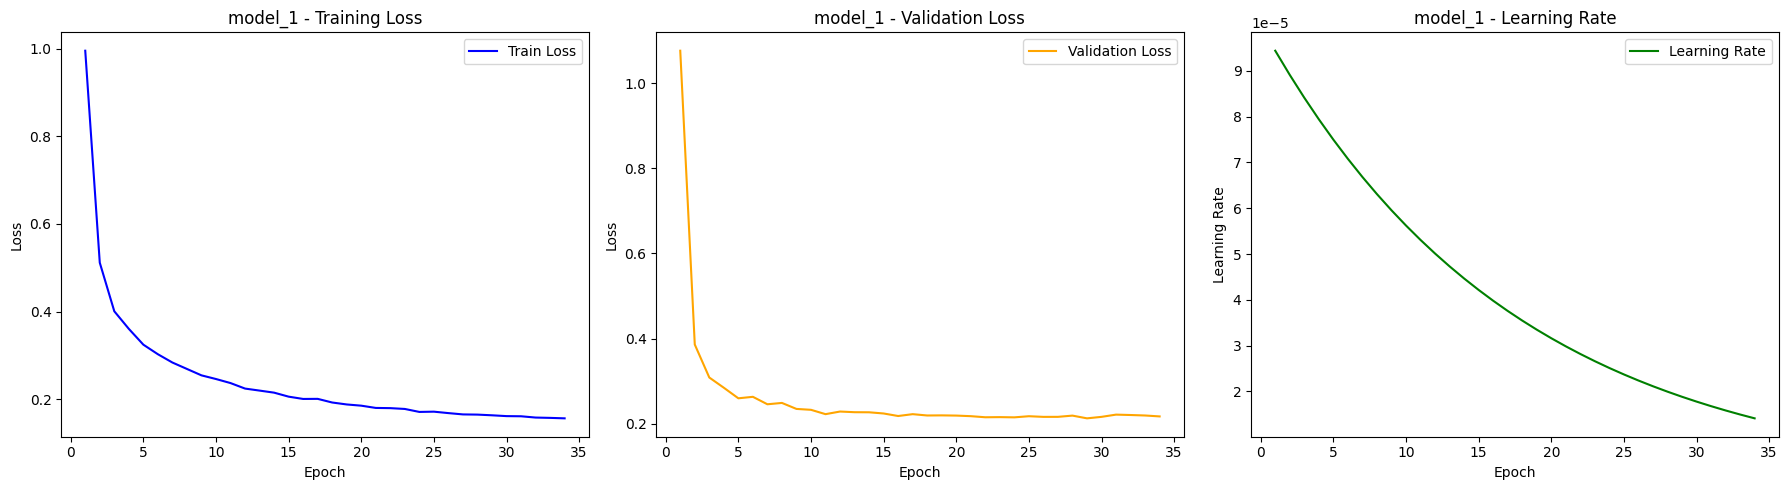

In [26]:
plot_training_info(model_stats, ['model_1'])

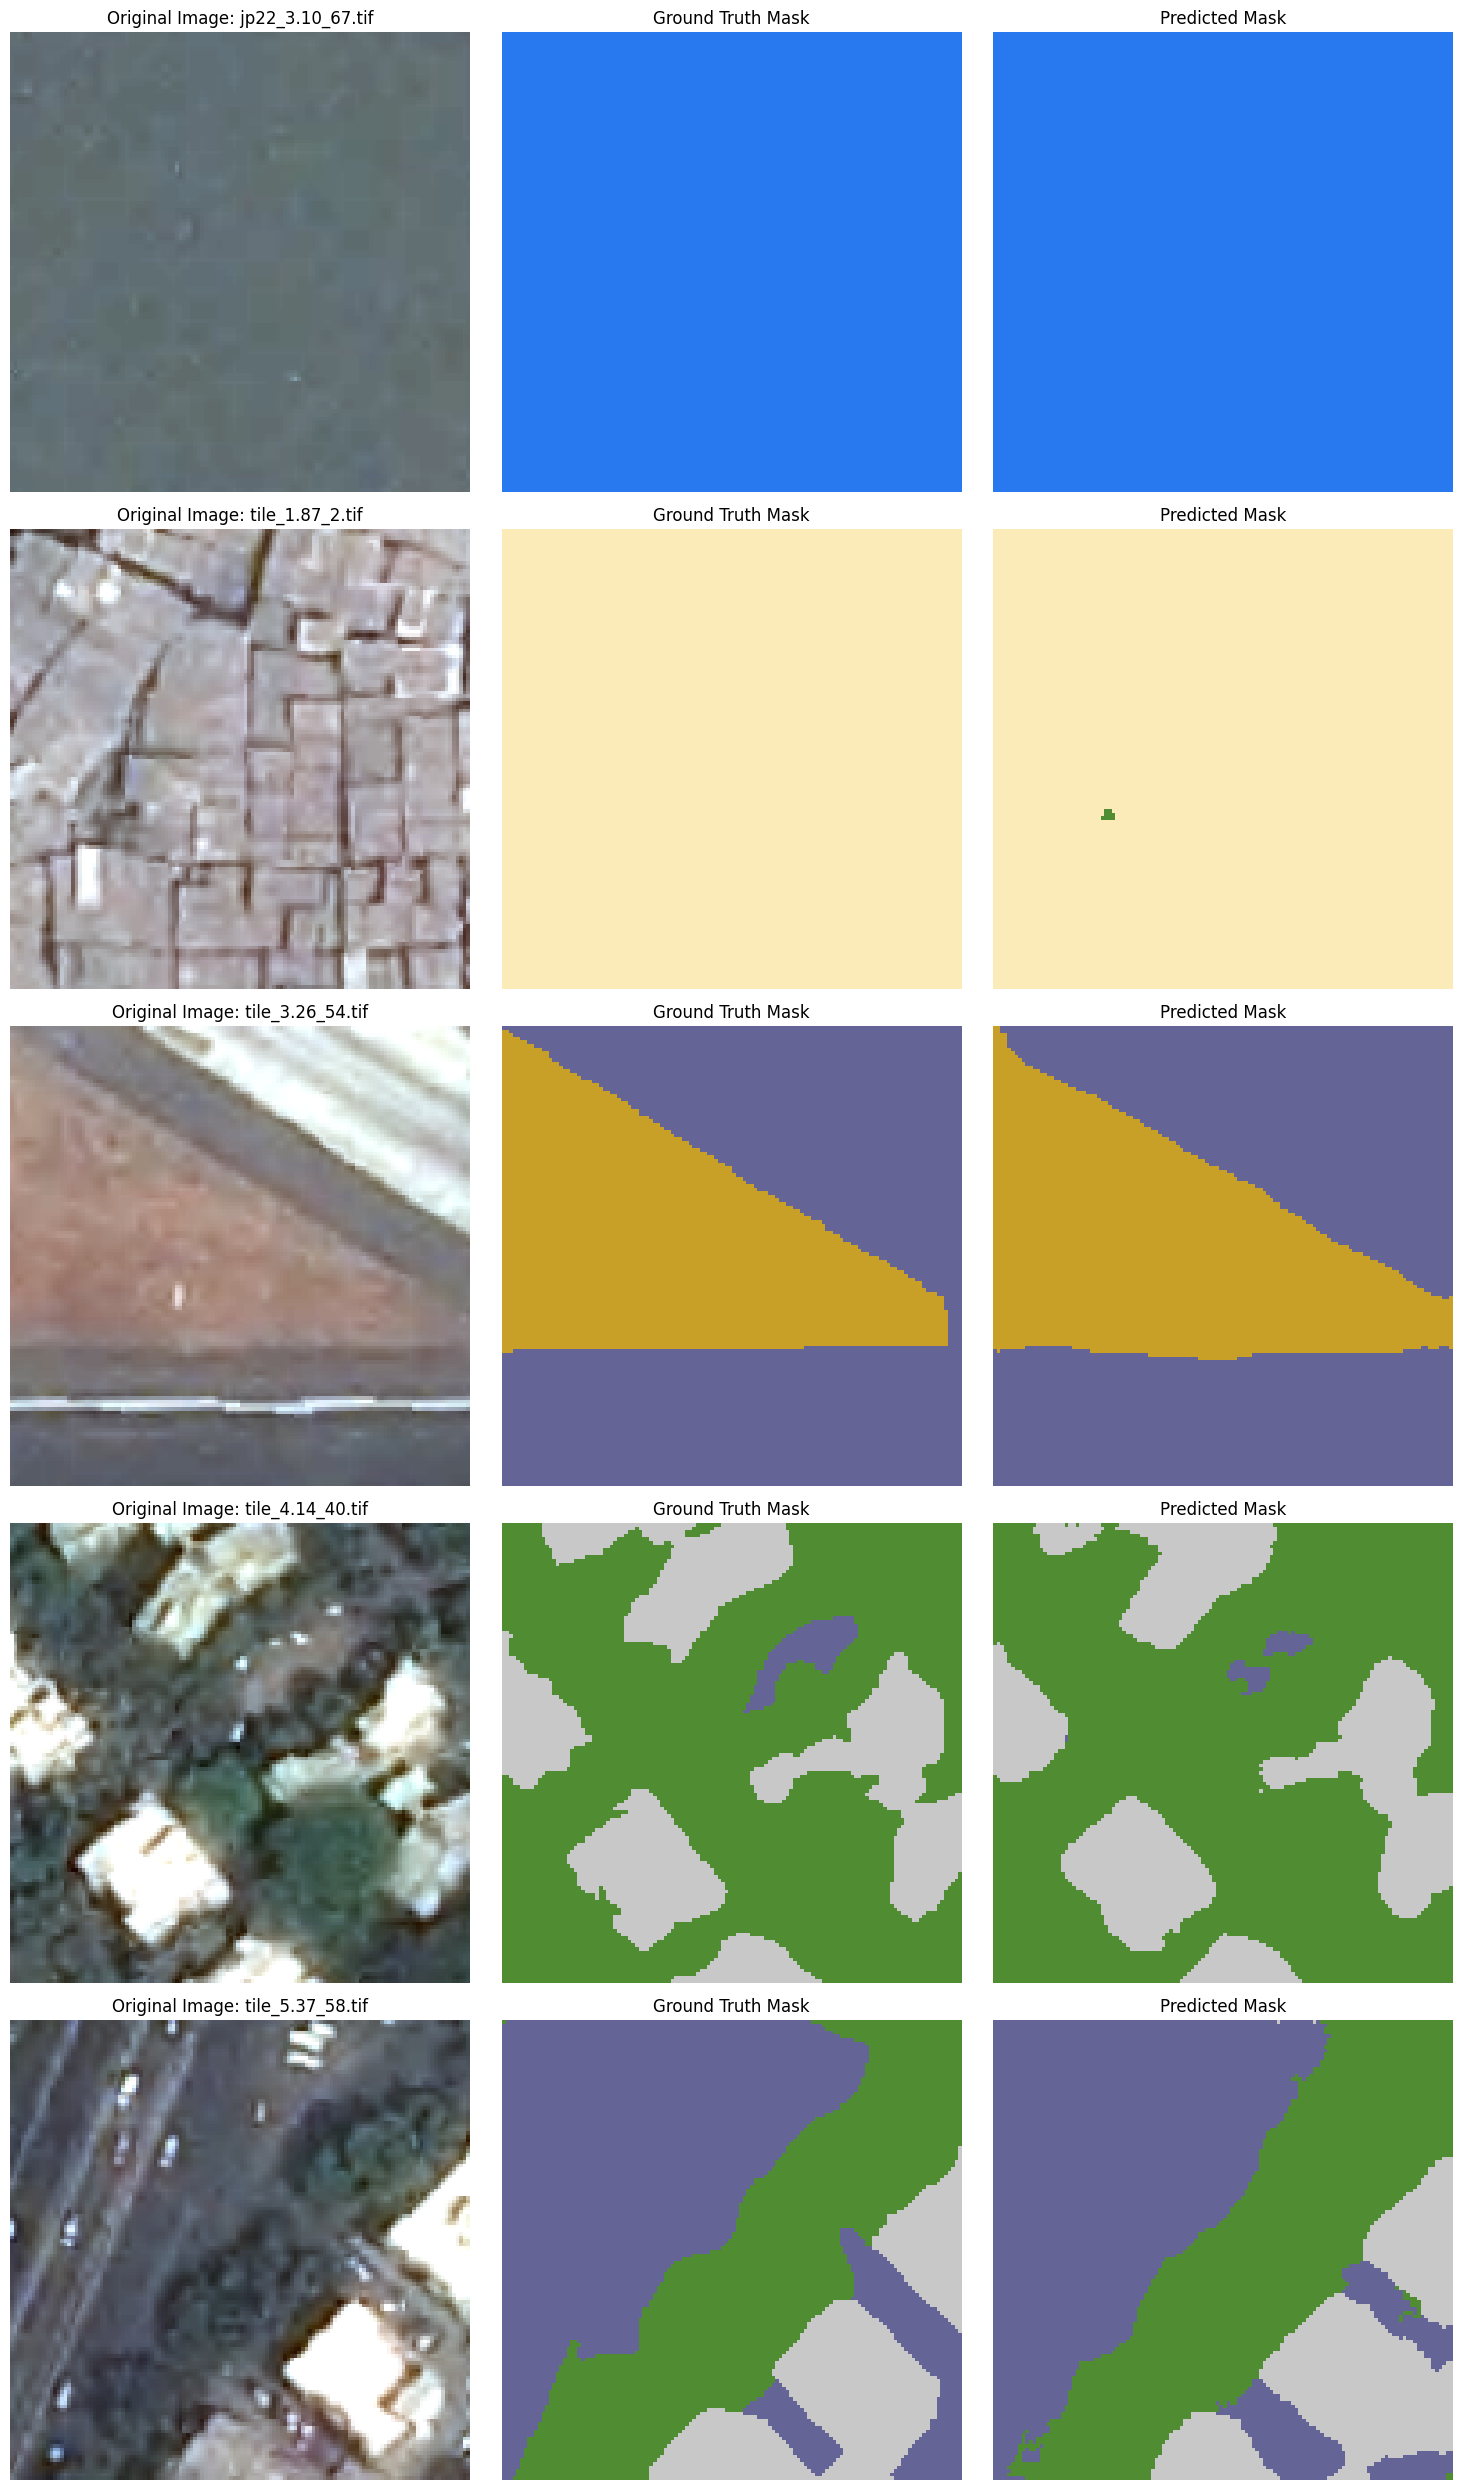

In [27]:
visualize_predictions_grid(visualization_images, test_dataset, model_1, class_dict_path, device)

In [48]:
model_2 = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=7
).cuda()

optimizer = optim.Adam(model_2.parameters(), lr=1e-4)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

early_stopping = EarlyStopping(patience=5, verbose=True)

def dice_loss(pred, target, smooth=1e-6, ignore_class_idx=6):
    """
    Compute Dice Loss for multi-class segmentation, excluding a specific class.

    Args:
        pred: Predicted logits (B, C, H, W).
        target: Ground truth mask (B, H, W).
        smooth: Smoothing factor to avoid division by zero.
        ignore_class_idx: Index of the class to ignore (e.g., "unclassified pixels").

    Returns:
        Dice loss (float).
    """
    pred = torch.softmax(pred, dim=1)  # Apply softmax to logits
    target_one_hot = nn.functional.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

    if ignore_class_idx is not None:
        # Mask out the ignored class without in-place modification
        ignore_mask = torch.ones_like(pred, device=pred.device)
        ignore_mask[:, ignore_class_idx, :, :] = 0
        pred = pred * ignore_mask
        target_one_hot = target_one_hot * ignore_mask

    intersection = torch.sum(pred * target_one_hot, dim=(2, 3))
    union = torch.sum(pred, dim=(2, 3)) + torch.sum(target_one_hot, dim=(2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)

    return 1 - torch.mean(dice)


# Define class weights for CrossEntropyLoss
# Replace with weights computed from your dataset's class distribution
cross_entropy_loss = nn.CrossEntropyLoss()

# Combined loss function
def combined_loss(pred, target):
    ce_loss = cross_entropy_loss(pred, target)
    d_loss = dice_loss(pred, target)
    return ce_loss + d_loss

model_stats['model_2'] = {}
model_stats['model_2']['training'] = train_model(model_2, optimizer, train_loader, val_loader, scheduler,
                                     "models/n_second_unet_model.pth", early_stopping=early_stopping,
                                     loss_func=combined_loss)

avg_metrics, class_metrics = evaluate_model(model_2, test_loader, device, n_classes=7)
model_stats['model_2']['avg_metrics'] = avg_metrics
model_stats['model_2']['class_metrics'] = class_metrics

Epoch [1/40], Loss: 1.7791, LR: 0.000094
Epoch [1/40], Val Loss: 1.8995
Validation loss improved to: 1.8995
Epoch [2/40], Loss: 1.1869, LR: 0.000089
Epoch [2/40], Val Loss: 1.1320
Validation loss improved to: 1.1320
Epoch [3/40], Loss: 1.0613, LR: 0.000084
Epoch [3/40], Val Loss: 1.0024
Validation loss improved to: 1.0024
Epoch [4/40], Loss: 1.0030, LR: 0.000079
Epoch [4/40], Val Loss: 0.9036
Validation loss improved to: 0.9036
Epoch [5/40], Loss: 0.9665, LR: 0.000075
Epoch [5/40], Val Loss: 0.8942
Validation loss improved to: 0.8942
Epoch [6/40], Loss: 0.9422, LR: 0.000071
Epoch [6/40], Val Loss: 0.8901
Validation loss improved to: 0.8901
Epoch [7/40], Loss: 0.9127, LR: 0.000067
Epoch [7/40], Val Loss: 0.8772
Validation loss improved to: 0.8772
Epoch [8/40], Loss: 0.8962, LR: 0.000063
Epoch [8/40], Val Loss: 0.8736
Validation loss improved to: 0.8736
Epoch [9/40], Loss: 0.8808, LR: 0.000060
Epoch [9/40], Val Loss: 0.8599
Validation loss improved to: 0.8599
Epoch [10/40], Loss: 0.8704,

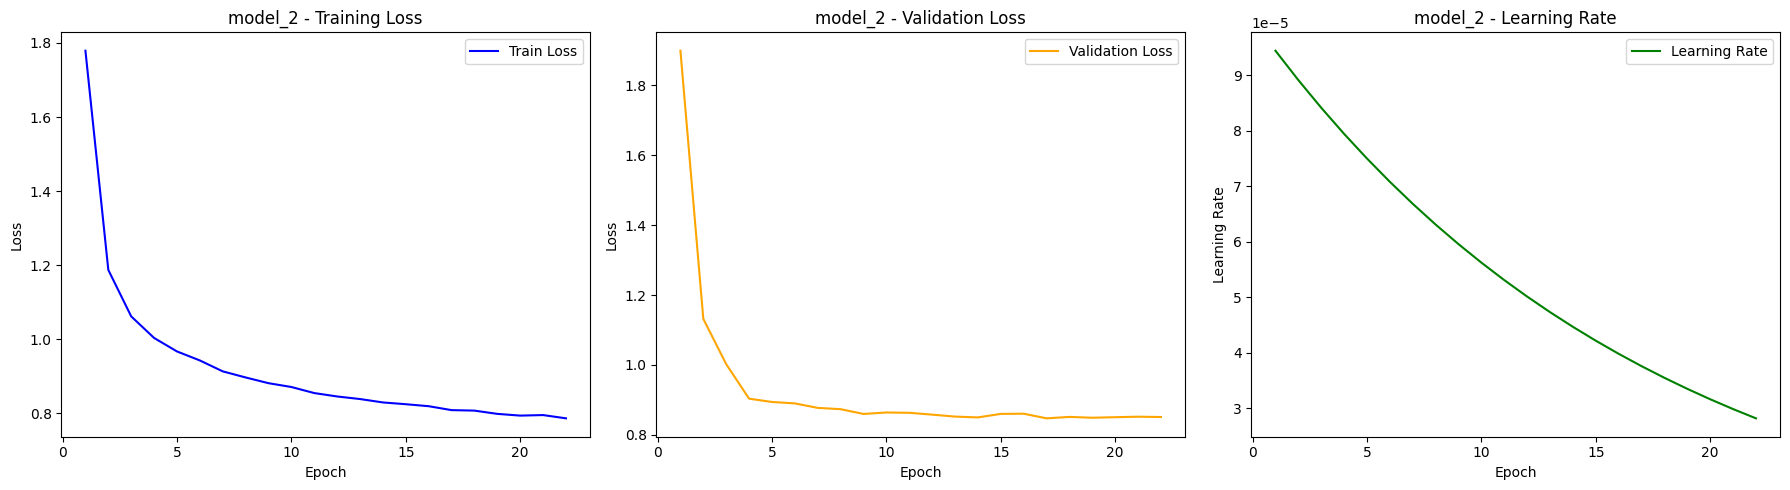

In [49]:
plot_training_info(model_stats, ['model_2'])

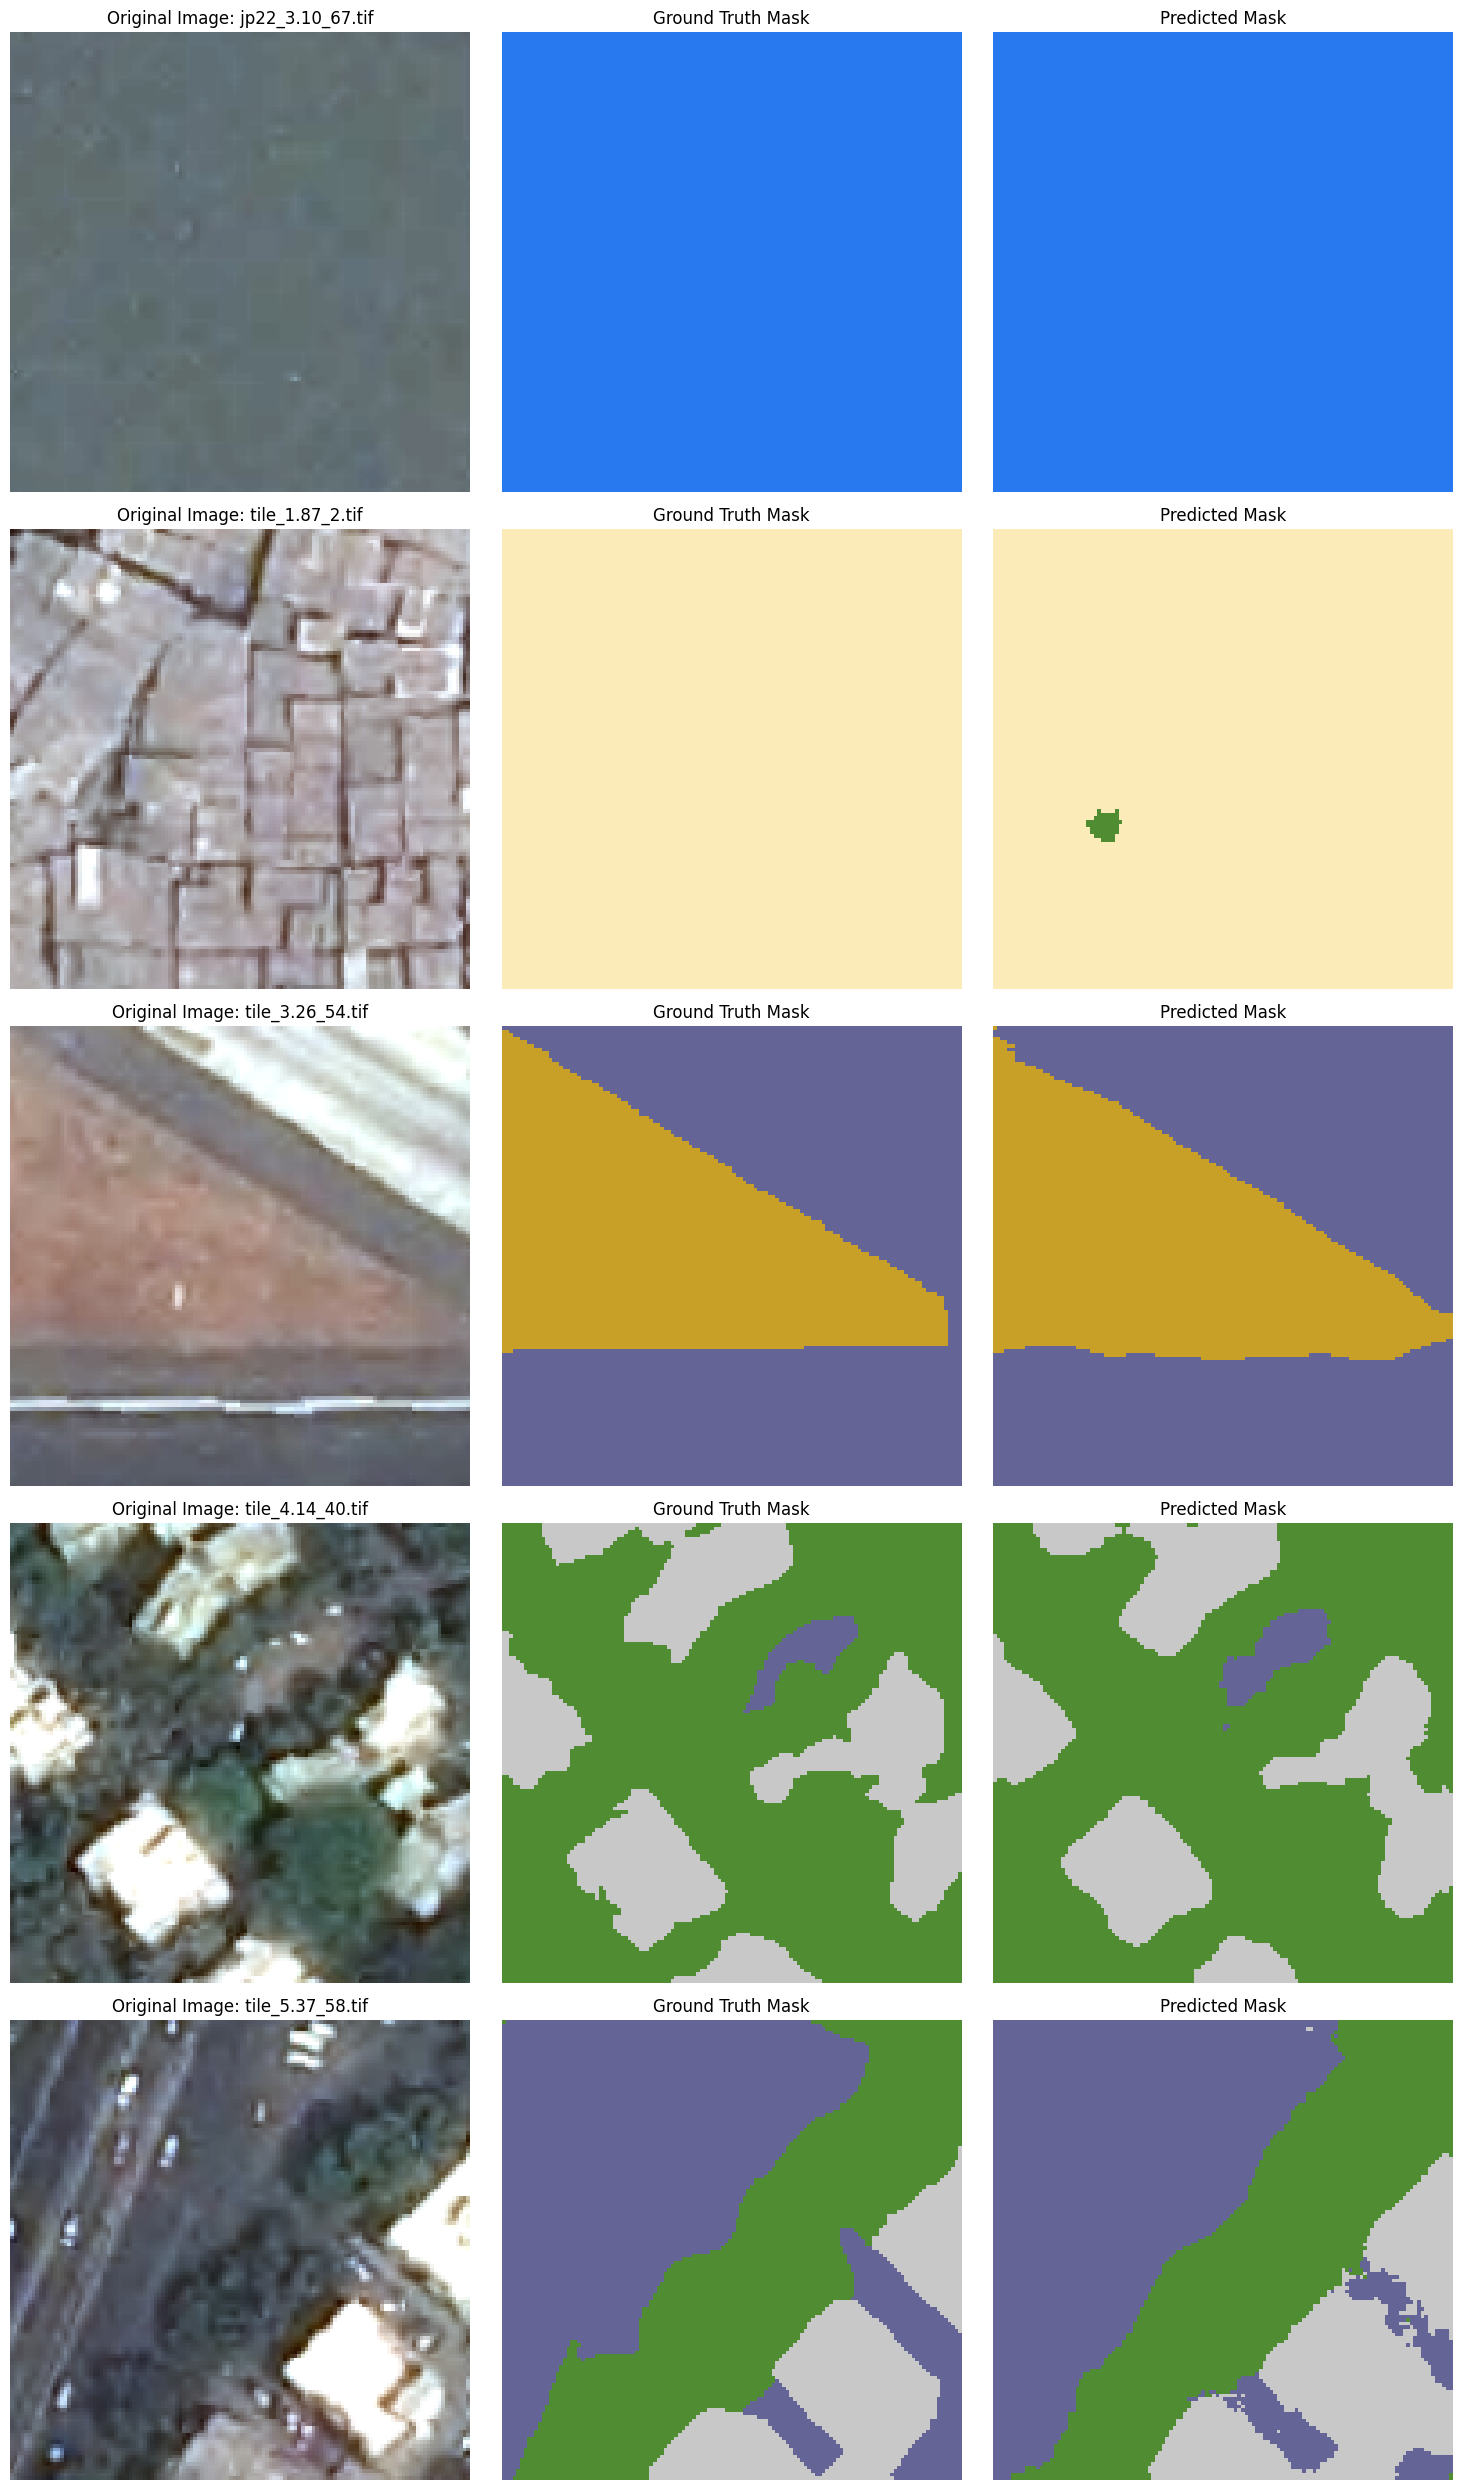

In [50]:
visualize_predictions_grid(visualization_images, test_dataset, model_2, class_dict_path, device)

In [58]:
class_pixel_counts = np.zeros(7, dtype=np.int64)

data_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

for _, masks in data_loader:
    masks = masks.numpy()
    for c in range(7):
        class_pixel_counts[c] += np.sum(masks == c)
print('Pixel counts: ', class_pixel_counts)

total_pixels = np.sum(class_pixel_counts)
print('Total: ', total_pixels)

class_frequencies = class_pixel_counts / total_pixels
print(class_frequencies)

class_weights = 1.0 / class_frequencies
class_weights[6] *= 0.001
print('Weights: ', class_weights)

norm_weights = class_weights / np.sum(class_weights)
print('Normalized weights: ', norm_weights)

Pixel counts:  [12921604 11358632 13436578 22423411 18735038 37789523   120366]
Total:  116785152
[0.11064424 0.09726093 0.11505382 0.19200567 0.16042312 0.32358157
 0.00103066]
Weights:  [ 9.0379764  10.28162124  8.69158442  5.20817961  6.23351562  3.09041085
  0.97025034]
Normalized weights:  [0.20770493 0.23628557 0.19974437 0.11969102 0.14325462 0.07102182
 0.02229767]


In [59]:
model_3 = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=7
).cuda()

optimizer = optim.Adam(model_3.parameters(), lr=1e-4)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

early_stopping = EarlyStopping(patience=5, verbose=True)

def dice_loss(pred, target, smooth=1e-6, ignore_class_idx=6):
    """
    Compute Dice Loss for multi-class segmentation, excluding a specific class.

    Args:
        pred: Predicted logits (B, C, H, W).
        target: Ground truth mask (B, H, W).
        smooth: Smoothing factor to avoid division by zero.
        ignore_class_idx: Index of the class to ignore (e.g., "unclassified pixels").

    Returns:
        Dice loss (float).
    """
    pred = torch.softmax(pred, dim=1)  # Apply softmax to logits
    target_one_hot = nn.functional.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

    if ignore_class_idx is not None:
        # Mask out the ignored class without in-place modification
        ignore_mask = torch.ones_like(pred, device=pred.device)
        ignore_mask[:, ignore_class_idx, :, :] = 0
        pred = pred * ignore_mask
        target_one_hot = target_one_hot * ignore_mask

    intersection = torch.sum(pred * target_one_hot, dim=(2, 3))
    union = torch.sum(pred, dim=(2, 3)) + torch.sum(target_one_hot, dim=(2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)

    return 1 - torch.mean(dice)


# Define class weights for CrossEntropyLoss
# Replace with weights computed from your dataset's class distribution
cross_entropy_loss = nn.CrossEntropyLoss(weight=torch.tensor(norm_weights, dtype=torch.float32).cuda())

# Combined loss function
def combined_loss(pred, target):
    ce_loss = cross_entropy_loss(pred, target)
    d_loss = dice_loss(pred, target)
    return ce_loss + d_loss

model_stats['model_3'] = {}
model_stats['model_3']['training'] = train_model(model_3, optimizer, train_loader, val_loader, scheduler,
                                     "models/n_third_unet_model.pth", early_stopping=early_stopping,
                                     loss_func=combined_loss)

avg_metrics, class_metrics = evaluate_model(model_3, test_loader, device, n_classes=7)
model_stats['model_3']['avg_metrics'] = avg_metrics
model_stats['model_3']['class_metrics'] = class_metrics

Epoch [1/40], Loss: 1.9222, LR: 0.000094
Epoch [1/40], Val Loss: 1.7676
Validation loss improved to: 1.7676
Epoch [2/40], Loss: 1.2674, LR: 0.000089
Epoch [2/40], Val Loss: 1.0639
Validation loss improved to: 1.0639
Epoch [3/40], Loss: 1.1301, LR: 0.000084
Epoch [3/40], Val Loss: 0.9583
Validation loss improved to: 0.9583
Epoch [4/40], Loss: 1.0648, LR: 0.000079
Epoch [4/40], Val Loss: 0.9008
Validation loss improved to: 0.9008
Epoch [5/40], Loss: 1.0200, LR: 0.000075
Epoch [5/40], Val Loss: 0.8796
Validation loss improved to: 0.8796
Epoch [6/40], Loss: 0.9870, LR: 0.000071
Epoch [6/40], Val Loss: 0.8733
Validation loss improved to: 0.8733
Epoch [7/40], Loss: 0.9668, LR: 0.000067
Epoch [7/40], Val Loss: 0.8694
Validation loss improved to: 0.8694
Epoch [8/40], Loss: 0.9442, LR: 0.000063
Epoch [8/40], Val Loss: 0.8569
Validation loss improved to: 0.8569
Epoch [9/40], Loss: 0.9299, LR: 0.000060
Epoch [9/40], Val Loss: 0.8615
EarlyStopping counter: 1 out of 5
Epoch [10/40], Loss: 0.9176, L

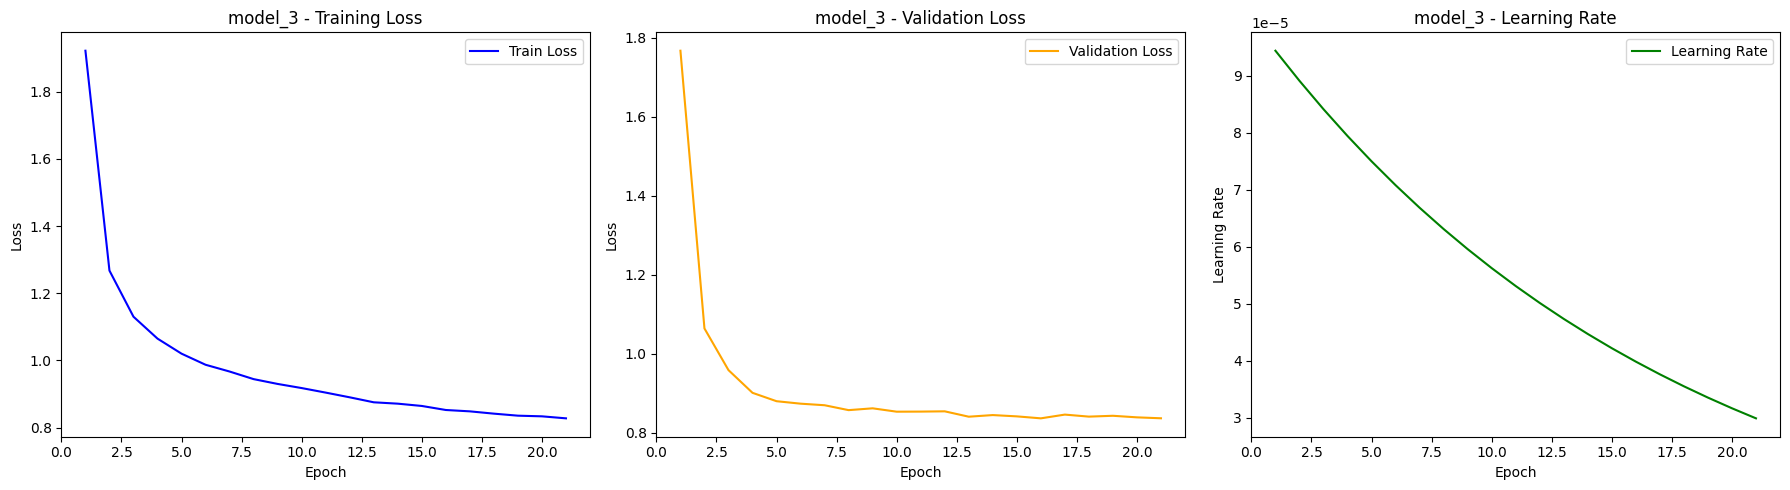

In [60]:
plot_training_info(model_stats, ['model_3'])

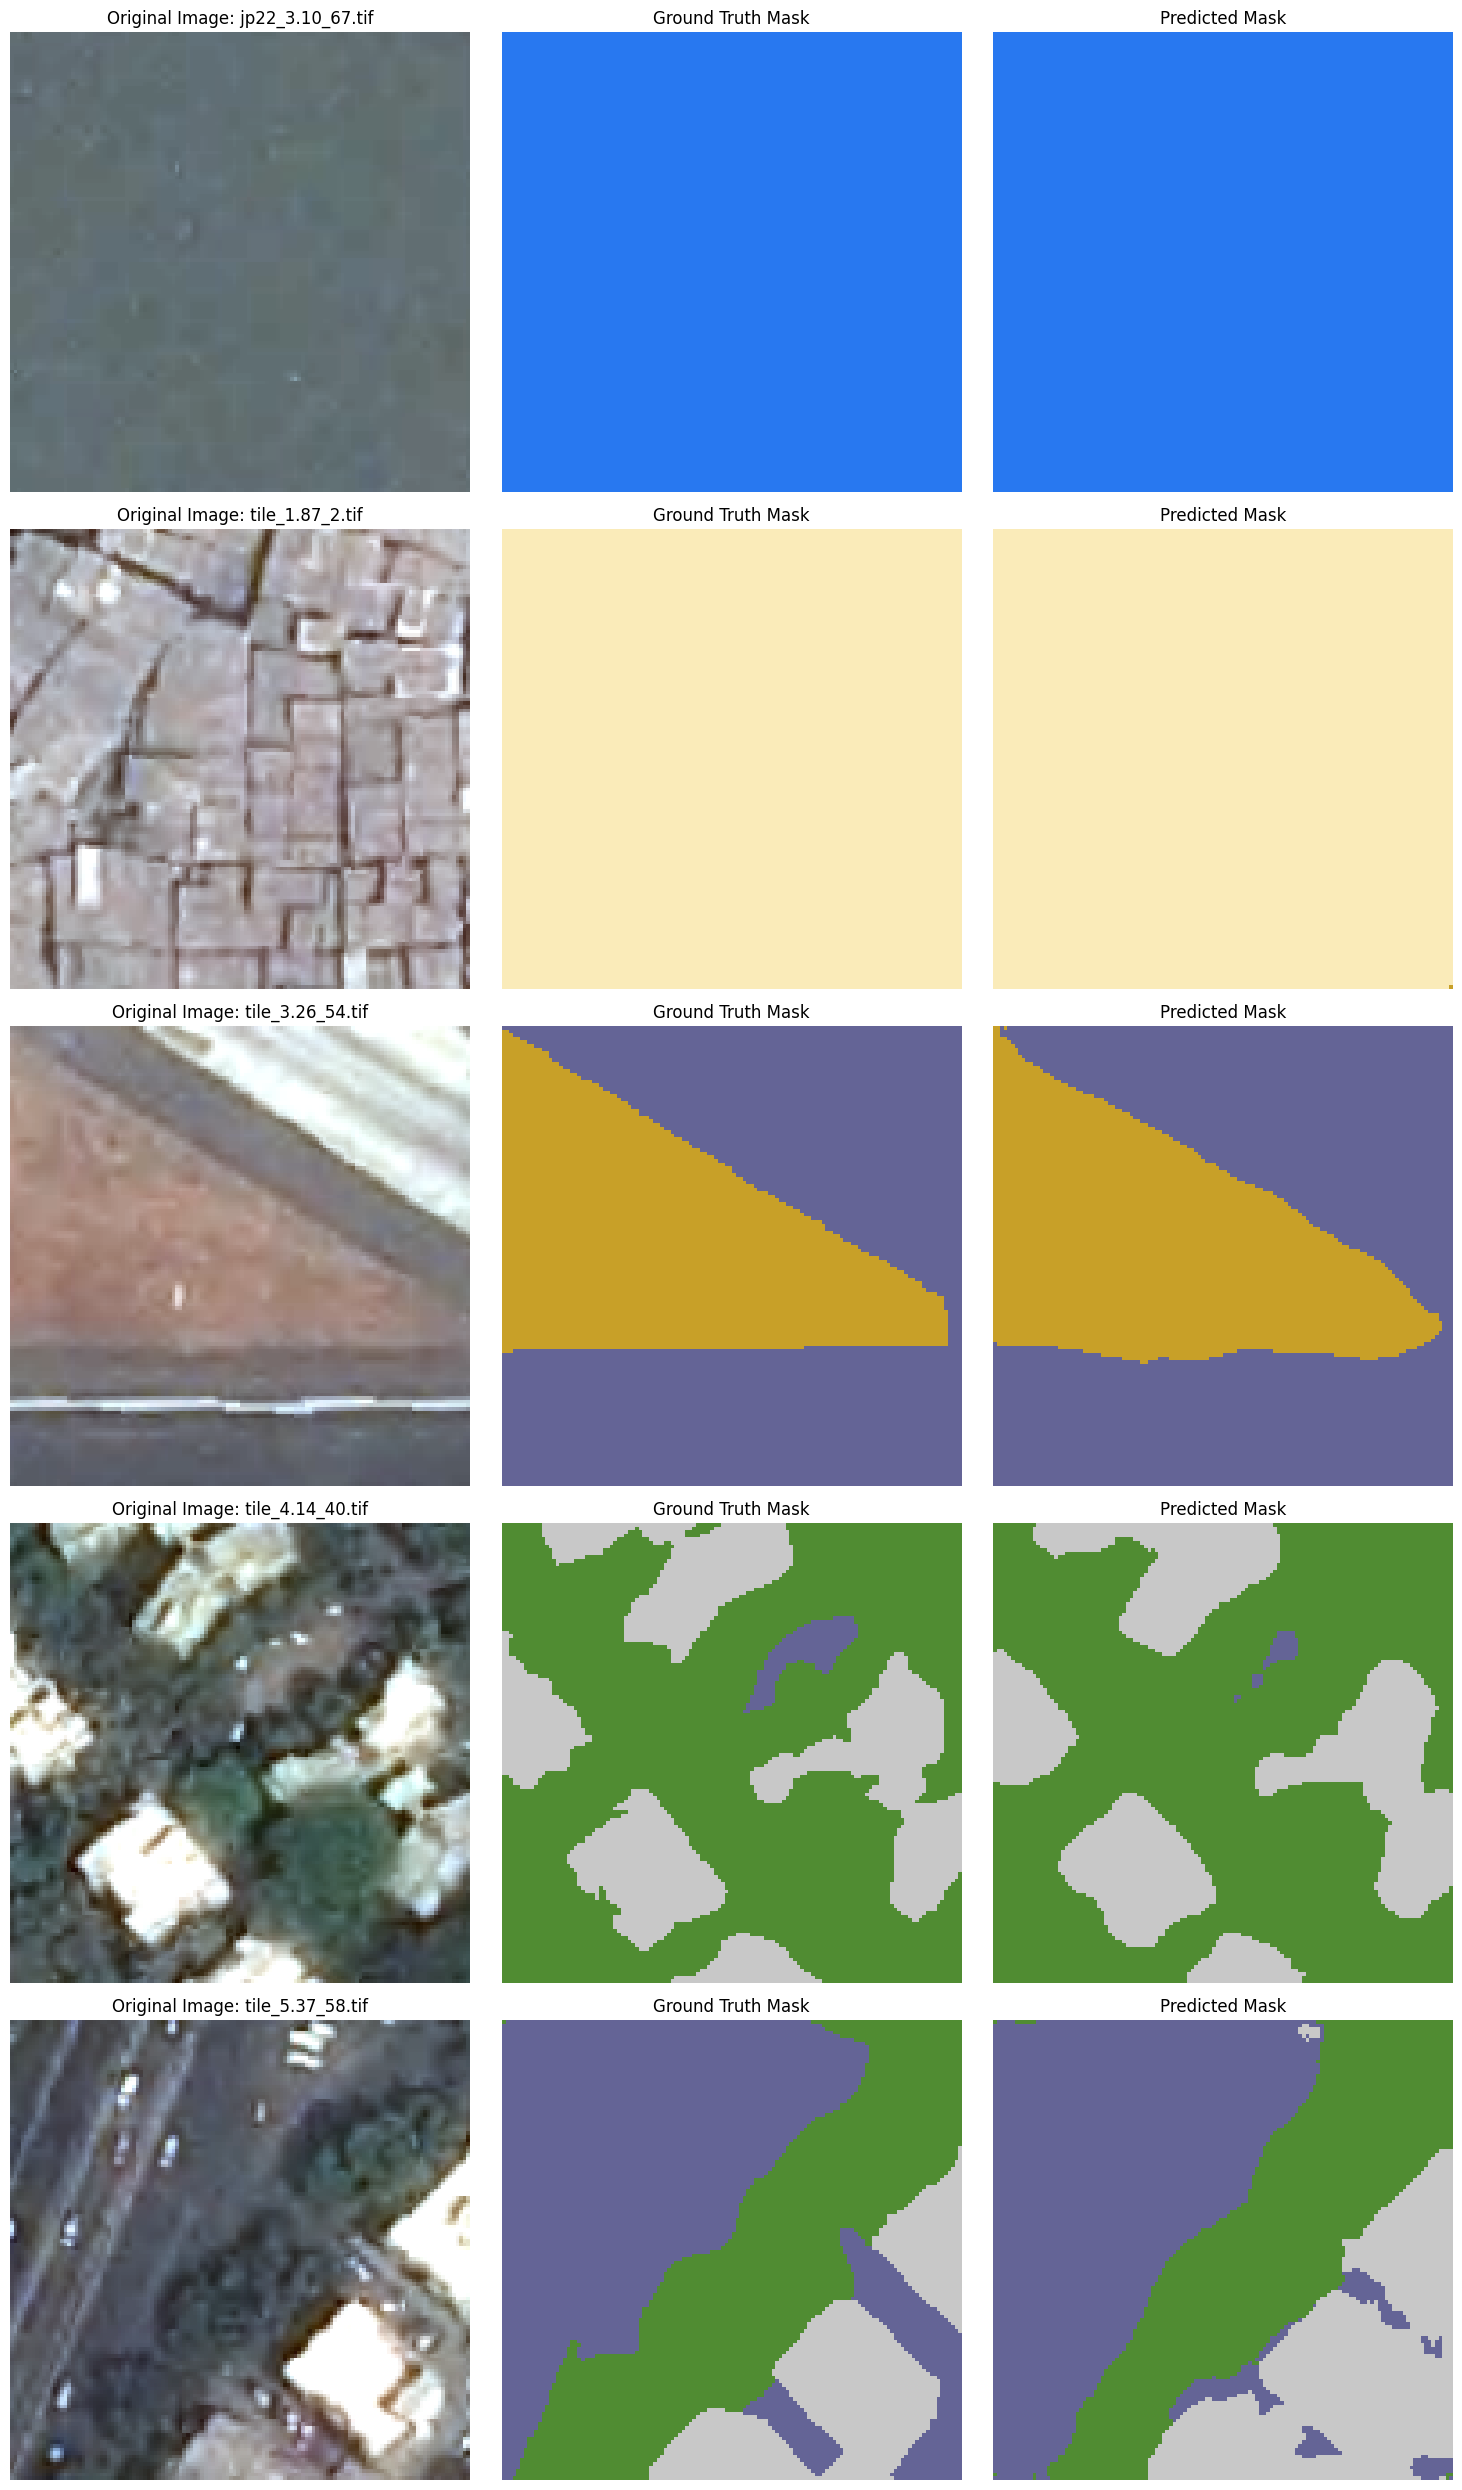

In [66]:
visualize_predictions_grid(visualization_images, test_dataset, model_3, class_dict_path, device)

In [67]:
model_4 = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=7,
    encoder_depth=4,
    decoder_channels=[256, 128, 64, 32]
).cuda()

optimizer = optim.Adam(model_4.parameters(), lr=1e-4)

def lr_lambda(epoch):
    return 0.1 ** (epoch / 40)

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

early_stopping = EarlyStopping(patience=5, verbose=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

model_stats['model_4'] = {}
model_stats['model_4']['training'] = train_model(model_4, optimizer, train_loader, val_loader, scheduler,
                                     "models/n_fourth_unet_model.pth", early_stopping=early_stopping)

Epoch [1/40], Loss: 0.8470, LR: 0.000094
Epoch [1/40], Val Loss: 1.0594
Validation loss improved to: 1.0594
Epoch [2/40], Loss: 0.4020, LR: 0.000089
Epoch [2/40], Val Loss: 0.3825
Validation loss improved to: 0.3825
Epoch [3/40], Loss: 0.3425, LR: 0.000084
Epoch [3/40], Val Loss: 0.2700
Validation loss improved to: 0.2700
Epoch [4/40], Loss: 0.3177, LR: 0.000079
Epoch [4/40], Val Loss: 0.2459
Validation loss improved to: 0.2459
Epoch [5/40], Loss: 0.2913, LR: 0.000075
Epoch [5/40], Val Loss: 0.2368
Validation loss improved to: 0.2368
Epoch [6/40], Loss: 0.2786, LR: 0.000071
Epoch [6/40], Val Loss: 0.2201
Validation loss improved to: 0.2201
Epoch [7/40], Loss: 0.2601, LR: 0.000067
Epoch [7/40], Val Loss: 0.2220
EarlyStopping counter: 1 out of 5
Epoch [8/40], Loss: 0.2505, LR: 0.000063
Epoch [8/40], Val Loss: 0.2099
Validation loss improved to: 0.2099
Epoch [9/40], Loss: 0.2483, LR: 0.000060
Epoch [9/40], Val Loss: 0.2206
EarlyStopping counter: 1 out of 5
Epoch [10/40], Loss: 0.2392, LR:

In [72]:
avg_metrics, class_metrics = evaluate_model(model_4, test_loader, device, n_classes=7)
model_stats['model_4']['avg_metrics'] = avg_metrics
model_stats['model_4']['class_metrics'] = class_metrics

Average Metrics: {'avg_jaccard': 0.9125834481006108, 'avg_precision': 0.6428976370162832, 'avg_recall': 0.6192925364401064, 'avg_dice': 0.6195125471595039}
Class-wise Metrics: {'class_iou': [0.6272204960053704, 0.6758002619178509, 0.5301573856037138, 0.7681737609440138, 0.5503249927324526, 0.8827122854322427, 0.0], 'class_dice': [0.6517070793131317, 0.762041836455198, 0.5933666149654757, 0.8387220317838135, 0.5985299561692047, 0.8922203114297037, 0.0], 'class_precision': [0.6463434339069168, 0.7801922155805195, 0.6846993739787557, 0.8422590688079645, 0.6501890922026109, 0.8966002746372154, 0.0], 'class_recall': [0.6612036079779068, 0.7717984522412087, 0.5667665353232226, 0.8541741813602591, 0.5913292472196042, 0.8897757309585433, 0.0]}


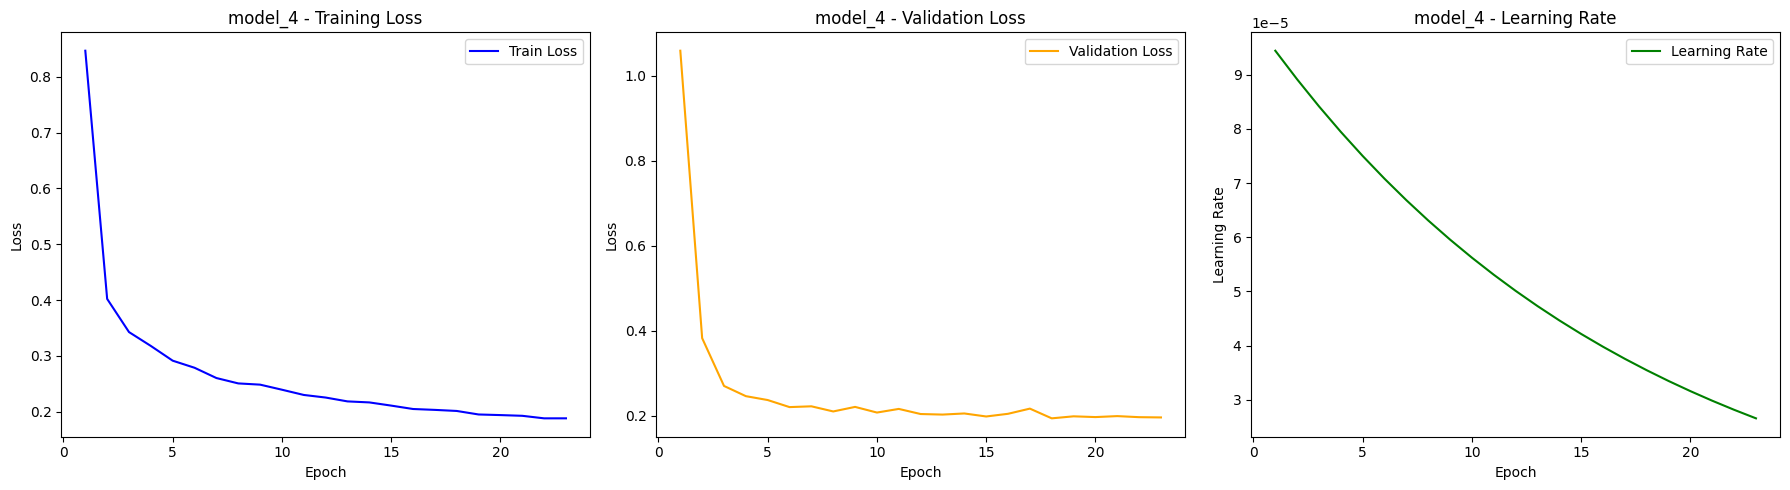

In [68]:
plot_training_info(model_stats, ['model_4'])

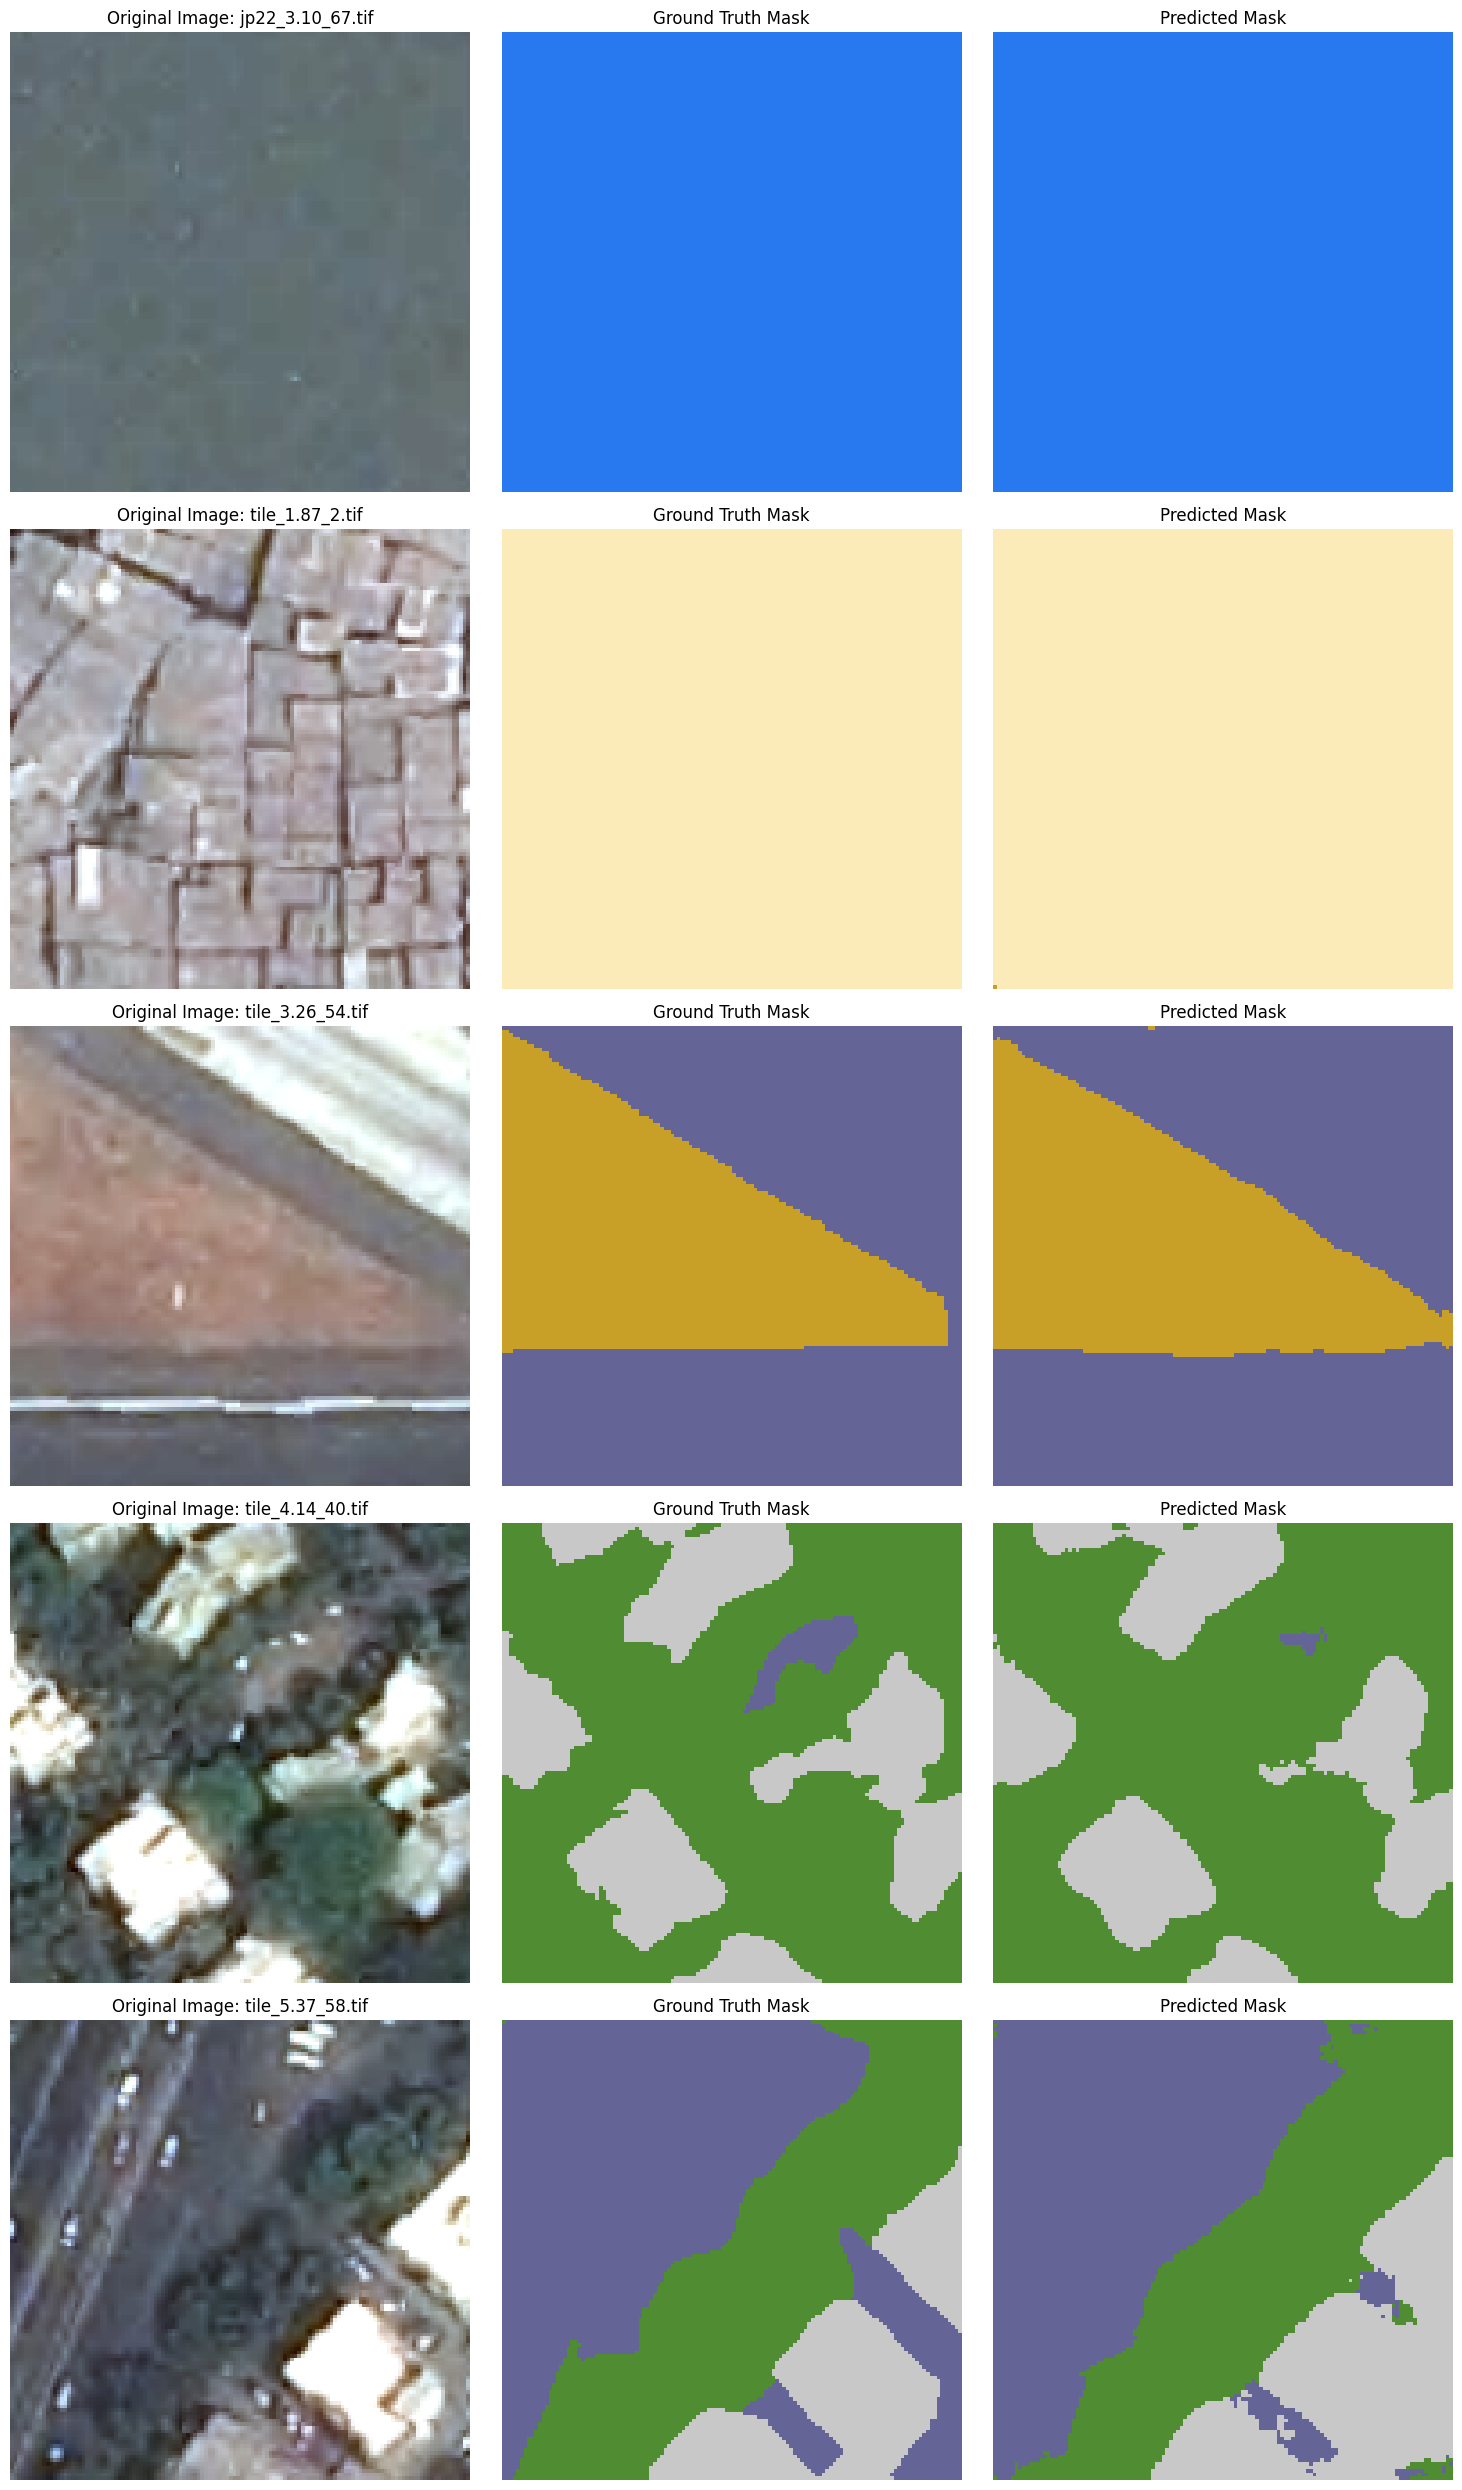

In [69]:
visualize_predictions_grid(visualization_images, test_dataset, model_4, class_dict_path, device)

In [71]:
model_5 = CustomUnet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=7,
    dropout_p=0.2
).cuda()

cross_entropy_loss = nn.CrossEntropyLoss()

# Combined loss function
def combined_loss(pred, target):
    ce_loss = cross_entropy_loss(pred, target)
    d_loss = dice_loss(pred, target)
    return ce_loss + d_loss

# Optimizer
optimizer = optim.Adam(model_5.parameters(), lr=1e-4)

# Learning rate scheduler
def lr_lambda(epoch):
    return 0.1 ** (epoch / 40)

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
early_stopping = EarlyStopping(patience=5, verbose=True)

# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

model_stats['model_5'] = {}
model_stats['model_5']['training'] = train_model(model_5, optimizer, train_loader, val_loader, scheduler,
                                     "models/n_fifth_unet_model.pth", early_stopping=early_stopping)

avg_metrics, class_metrics = evaluate_model(model_5, test_loader, device, n_classes=7)
model_stats['model_5']['avg_metrics'] = avg_metrics
model_stats['model_5']['class_metrics'] = class_metrics

Epoch [1/40], Loss: 1.0857, LR: 0.000094
Epoch [1/40], Val Loss: 0.7678
Validation loss improved to: 0.7678
Epoch [2/40], Loss: 0.5648, LR: 0.000089
Epoch [2/40], Val Loss: 0.4002
Validation loss improved to: 0.4002
Epoch [3/40], Loss: 0.4387, LR: 0.000084
Epoch [3/40], Val Loss: 0.2804
Validation loss improved to: 0.2804
Epoch [4/40], Loss: 0.3843, LR: 0.000079
Epoch [4/40], Val Loss: 0.2581
Validation loss improved to: 0.2581
Epoch [5/40], Loss: 0.3409, LR: 0.000075
Epoch [5/40], Val Loss: 0.2648
EarlyStopping counter: 1 out of 5
Epoch [6/40], Loss: 0.3193, LR: 0.000071
Epoch [6/40], Val Loss: 0.2503
Validation loss improved to: 0.2503
Epoch [7/40], Loss: 0.2988, LR: 0.000067
Epoch [7/40], Val Loss: 0.2397
Validation loss improved to: 0.2397
Epoch [8/40], Loss: 0.2826, LR: 0.000063
Epoch [8/40], Val Loss: 0.2406
EarlyStopping counter: 1 out of 5
Epoch [9/40], Loss: 0.2768, LR: 0.000060
Epoch [9/40], Val Loss: 0.2394
Validation loss improved to: 0.2394
Epoch [10/40], Loss: 0.2568, LR:

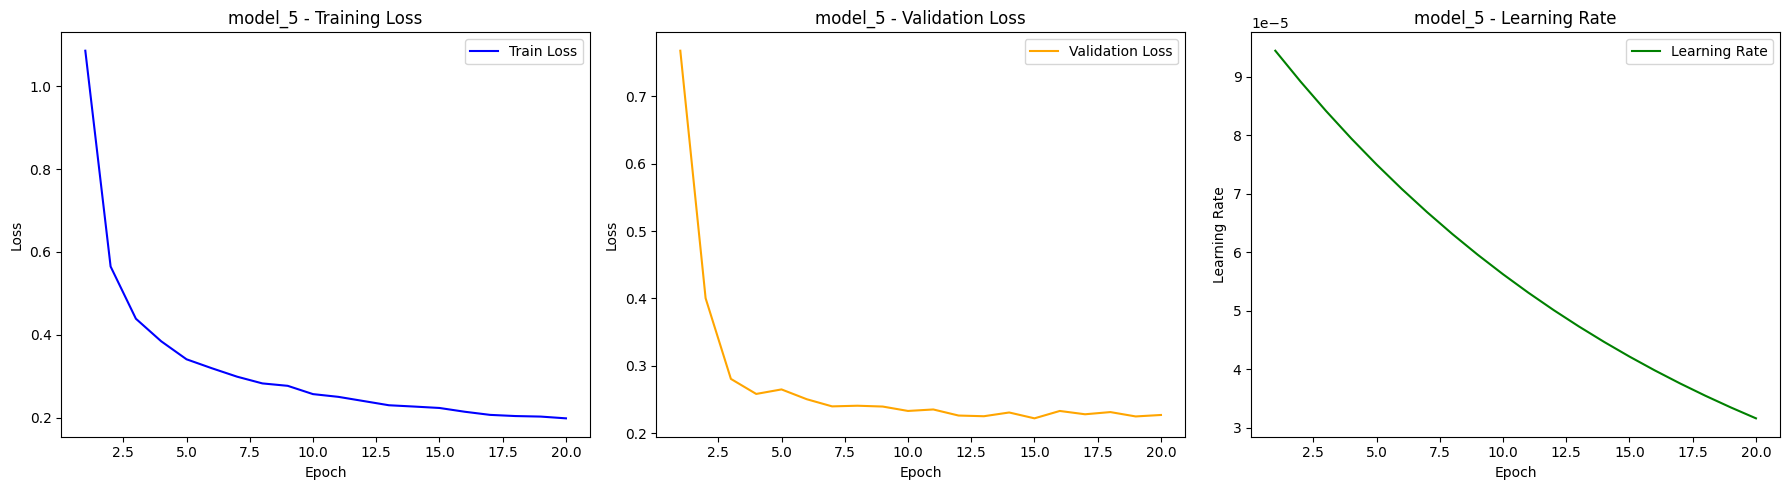

In [73]:
plot_training_info(model_stats, ['model_5'])

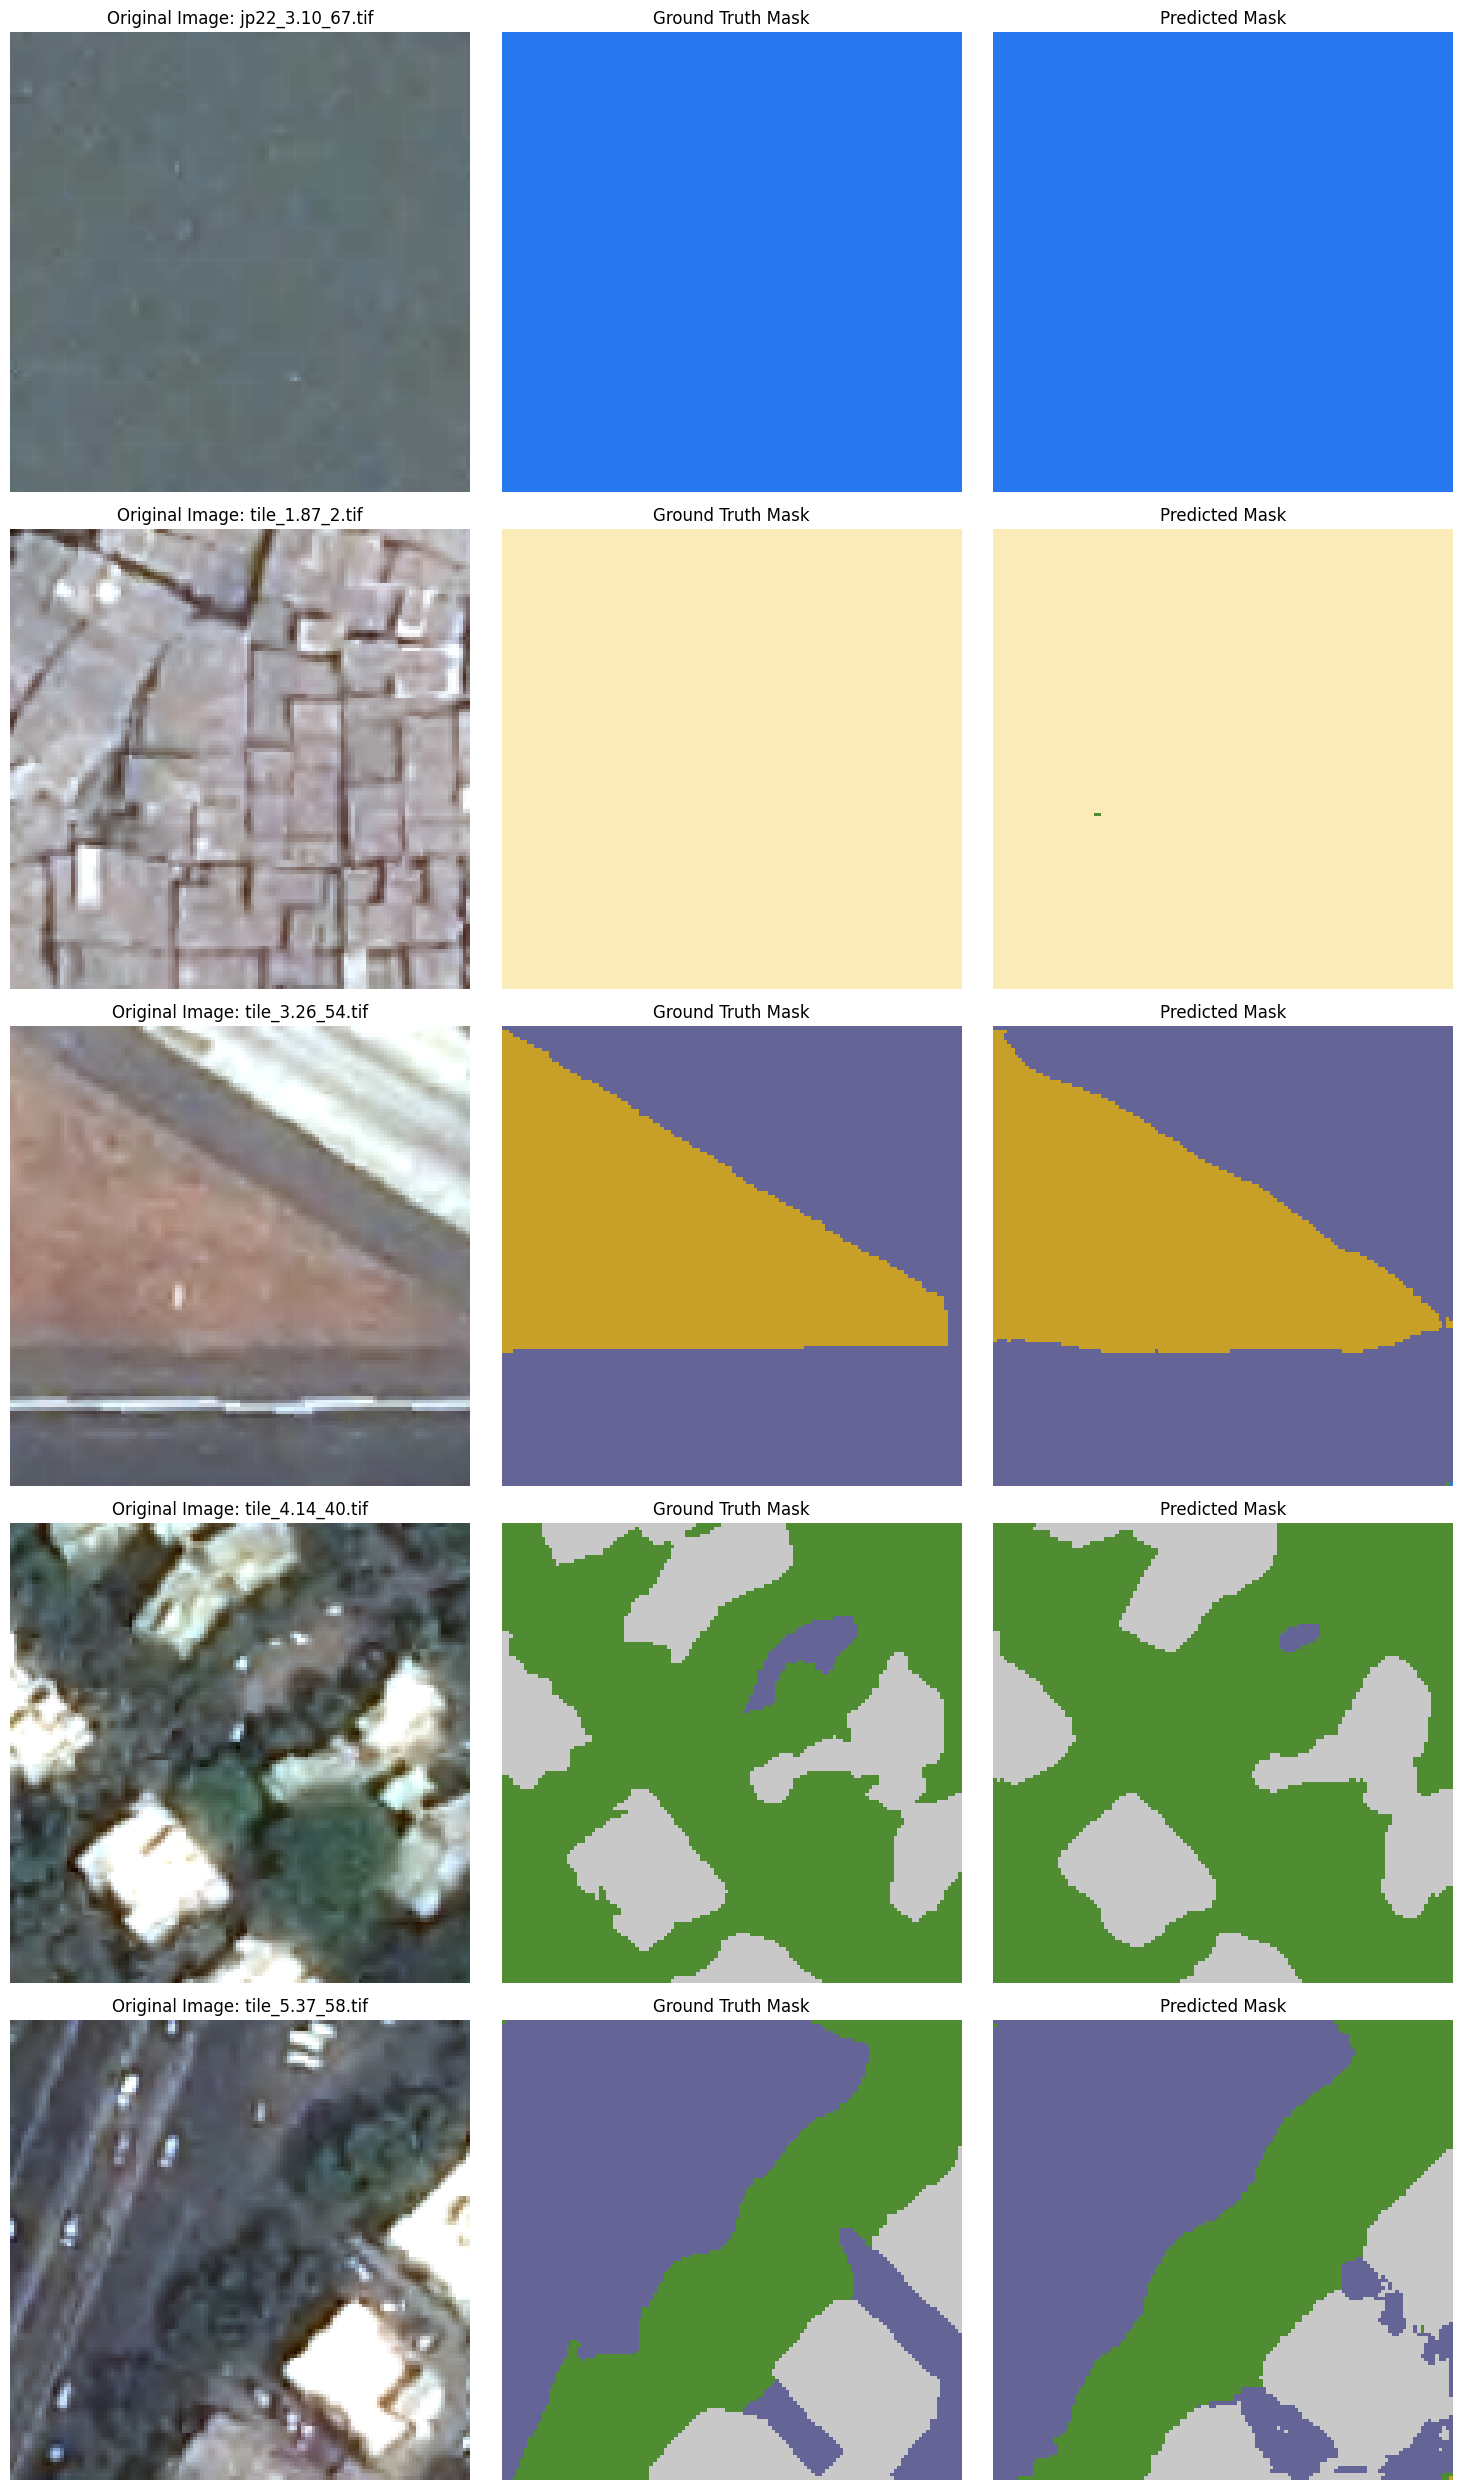

In [74]:
visualize_predictions_grid(visualization_images, test_dataset, model_5, class_dict_path, device)

In [76]:
model_6 = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=7,
    encoder_depth=4,
    decoder_channels=[256, 128, 64, 32],
    decoder_attention_type='scse'
).cuda()

ce_loss = nn.CrossEntropyLoss()
def combined_loss(pred, target):
    return ce_loss(pred, target) + dice_loss(pred, target)

optimizer = optim.Adam(model_6.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
early_stopping = EarlyStopping(patience=5, verbose=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

model_stats['model_6'] = {}
model_stats['model_6']['training'] = train_model(model_6, optimizer, train_loader, val_loader, scheduler,
                                     "models/n_sixth_unet_model.pth", early_stopping=early_stopping)

avg_metrics, class_metrics = evaluate_model(model_6, test_loader, device, n_classes=7)
model_stats['model_6']['avg_metrics'] = avg_metrics
model_stats['model_6']['class_metrics'] = class_metrics

Epoch [1/40], Loss: 0.8494, LR: 0.000094
Epoch [1/40], Val Loss: 1.0791
Validation loss improved to: 1.0791
Epoch [2/40], Loss: 0.4130, LR: 0.000089
Epoch [2/40], Val Loss: 0.3464
Validation loss improved to: 0.3464
Epoch [3/40], Loss: 0.3434, LR: 0.000084
Epoch [3/40], Val Loss: 0.2535
Validation loss improved to: 0.2535
Epoch [4/40], Loss: 0.3071, LR: 0.000079
Epoch [4/40], Val Loss: 0.2387
Validation loss improved to: 0.2387
Epoch [5/40], Loss: 0.2821, LR: 0.000075
Epoch [5/40], Val Loss: 0.2187
Validation loss improved to: 0.2187
Epoch [6/40], Loss: 0.2715, LR: 0.000071
Epoch [6/40], Val Loss: 0.2214
EarlyStopping counter: 1 out of 5
Epoch [7/40], Loss: 0.2508, LR: 0.000067
Epoch [7/40], Val Loss: 0.2214
EarlyStopping counter: 2 out of 5
Epoch [8/40], Loss: 0.2442, LR: 0.000063
Epoch [8/40], Val Loss: 0.2121
Validation loss improved to: 0.2121
Epoch [9/40], Loss: 0.2367, LR: 0.000060
Epoch [9/40], Val Loss: 0.2094
Validation loss improved to: 0.2094
Epoch [10/40], Loss: 0.2257, LR:

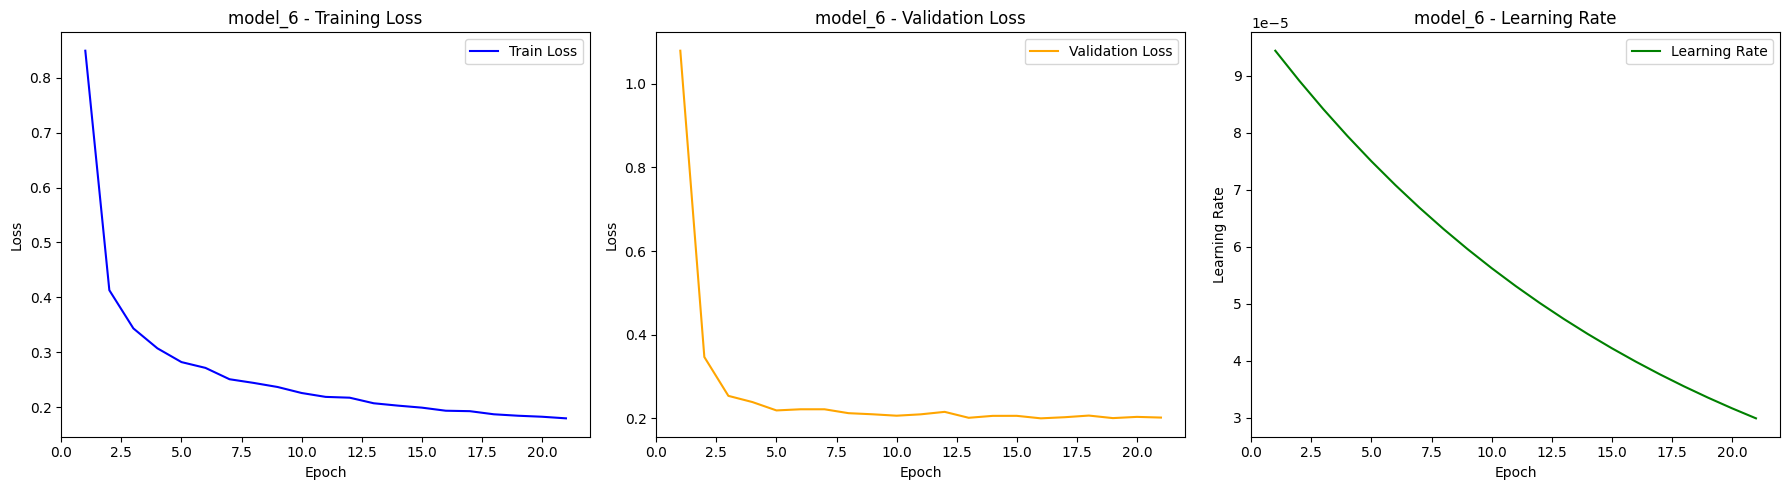

In [77]:
plot_training_info(model_stats, ['model_6'])

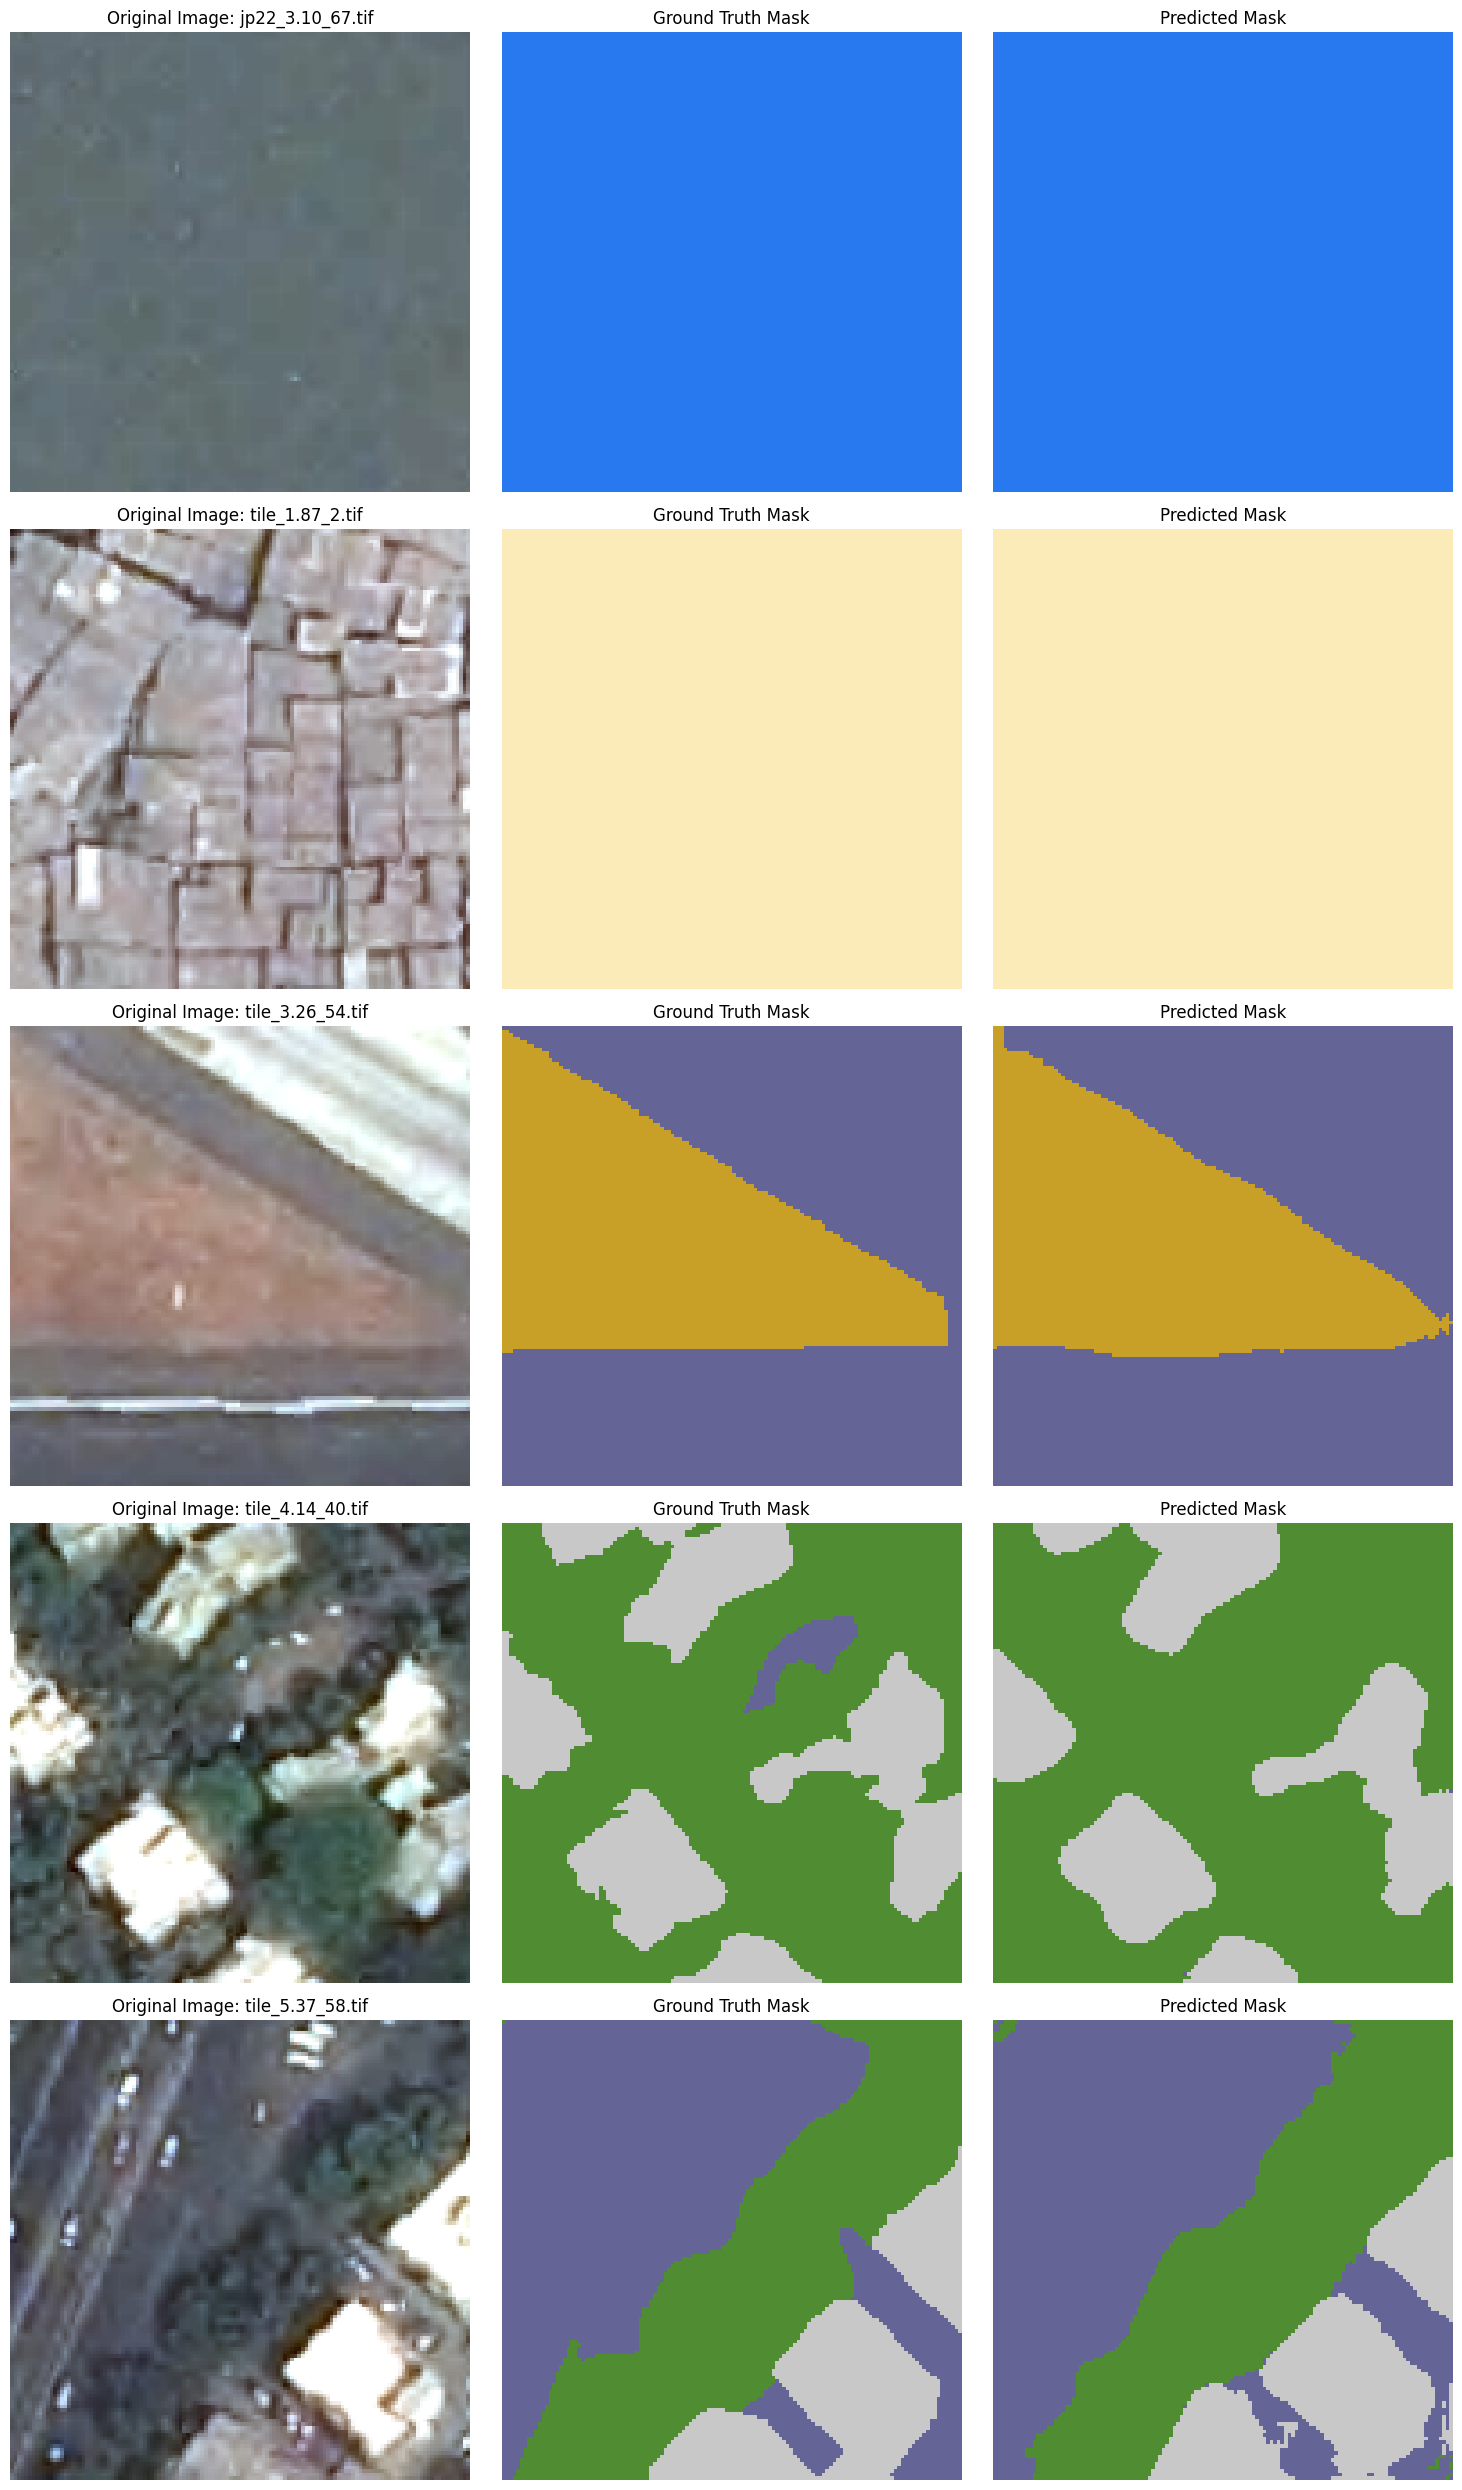

In [78]:
visualize_predictions_grid(visualization_images, test_dataset, model_6, class_dict_path, device)

In [80]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Define Weighted Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        return focal_loss.sum()

# Combined Loss Function
focal_loss = FocalLoss(weight=torch.tensor(norm_weights, dtype=torch.float32).cuda(), gamma=2)
def combined_loss(pred, target):
    return focal_loss(pred, target) + dice_loss(pred, target)

# Define Model 7
model_7 = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=7,
    encoder_depth=5,
    decoder_channels=[256, 128, 64, 32, 16],
    decoder_attention_type="scse"
).cuda()

# Optimizer
optimizer = optim.AdamW(model_7.parameters(), lr=1e-4, weight_decay=1e-4)

# Cosine Annealing Scheduler with Warm Restarts
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

# Early Stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Train and Validate Model
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

model_stats['model_7'] = {}
model_stats['model_7']['training'] = train_model(model_7, optimizer, train_loader, val_loader, scheduler,
                                     "models/n_seventh_unet_model.pth", early_stopping=early_stopping,
                                     loss_func=combined_loss)

Epoch [1/40], Loss: 0.7541, LR: 0.000098
Epoch [1/40], Val Loss: 0.7389
Validation loss improved to: 0.7389
Epoch [2/40], Loss: 0.6781, LR: 0.000091
Epoch [2/40], Val Loss: 0.6657
Validation loss improved to: 0.6657
Epoch [3/40], Loss: 0.6580, LR: 0.000080
Epoch [3/40], Val Loss: 0.6471
Validation loss improved to: 0.6471
Epoch [4/40], Loss: 0.6490, LR: 0.000066
Epoch [4/40], Val Loss: 0.6409
Validation loss improved to: 0.6409
Epoch [5/40], Loss: 0.6422, LR: 0.000051
Epoch [5/40], Val Loss: 0.6394
Validation loss improved to: 0.6394
Epoch [6/40], Loss: 0.6381, LR: 0.000035
Epoch [6/40], Val Loss: 0.6367
Validation loss improved to: 0.6367
Epoch [7/40], Loss: 0.6343, LR: 0.000021
Epoch [7/40], Val Loss: 0.6360
Validation loss improved to: 0.6360
Epoch [8/40], Loss: 0.6334, LR: 0.000010
Epoch [8/40], Val Loss: 0.6360
Validation loss improved to: 0.6360
Epoch [9/40], Loss: 0.6318, LR: 0.000003
Epoch [9/40], Val Loss: 0.6356
Validation loss improved to: 0.6356
Epoch [10/40], Loss: 0.6315,

In [82]:
avg_metrics, class_metrics = evaluate_model(model_7, test_loader, device, n_classes=7)
model_stats['model_7']['avg_metrics'] = avg_metrics
model_stats['model_7']['class_metrics'] = class_metrics

Average Metrics: {'avg_jaccard': 0.9146400173376279, 'avg_precision': 0.5754059388795968, 'avg_recall': 0.5628324735034312, 'avg_dice': 0.5604836349122334}
Class-wise Metrics: {'class_iou': [0.5532812509012048, 0.5579706175596955, 0.5245995563769296, 0.7573236478612372, 0.5176879081917048, 0.7273920531092605, 0.0], 'class_dice': [0.5771590511506621, 0.6331902796618549, 0.5903351743423438, 0.825841795558834, 0.5619009317836889, 0.7349582118882496, 0.0], 'class_precision': [0.5856952340862641, 0.655185994952259, 0.6309569643958447, 0.8460125291259692, 0.5720353925893167, 0.7379554570075234, 0.0], 'class_recall': [0.5731360707648397, 0.6428078433742664, 0.5921308823498949, 0.8177538371630657, 0.5792939555408607, 0.7347047253310914, 0.0]}


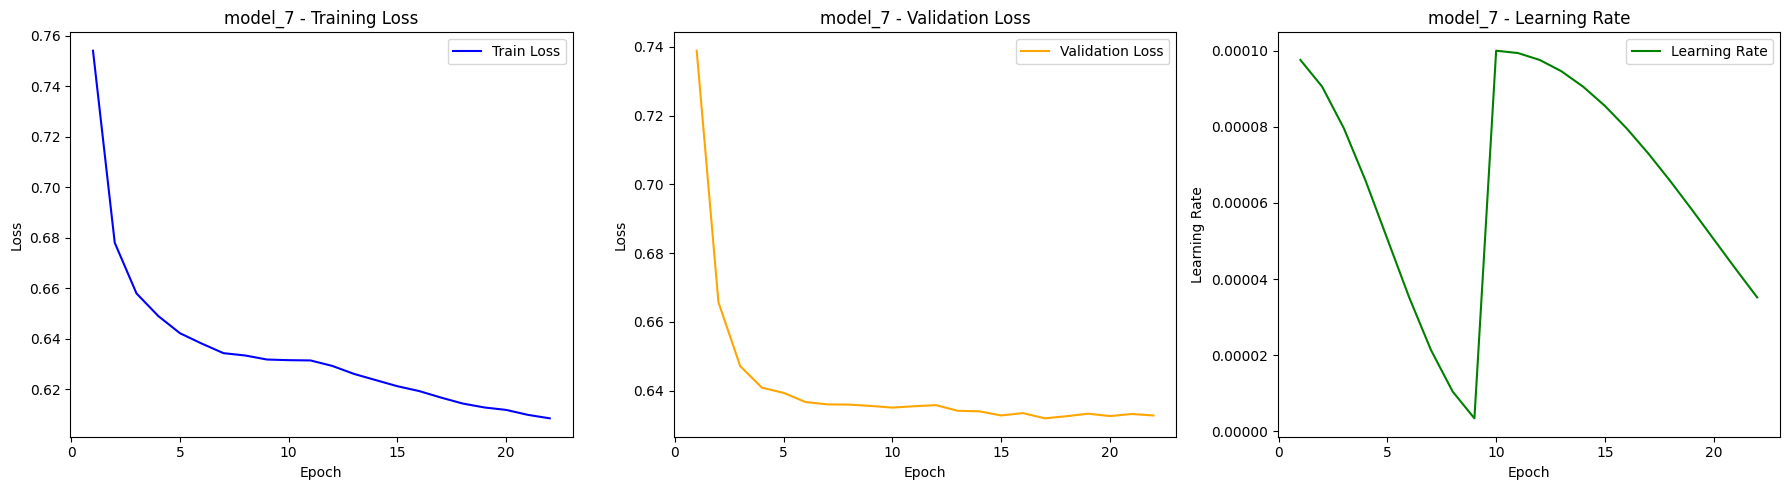

In [81]:
plot_training_info(model_stats, ['model_7'])

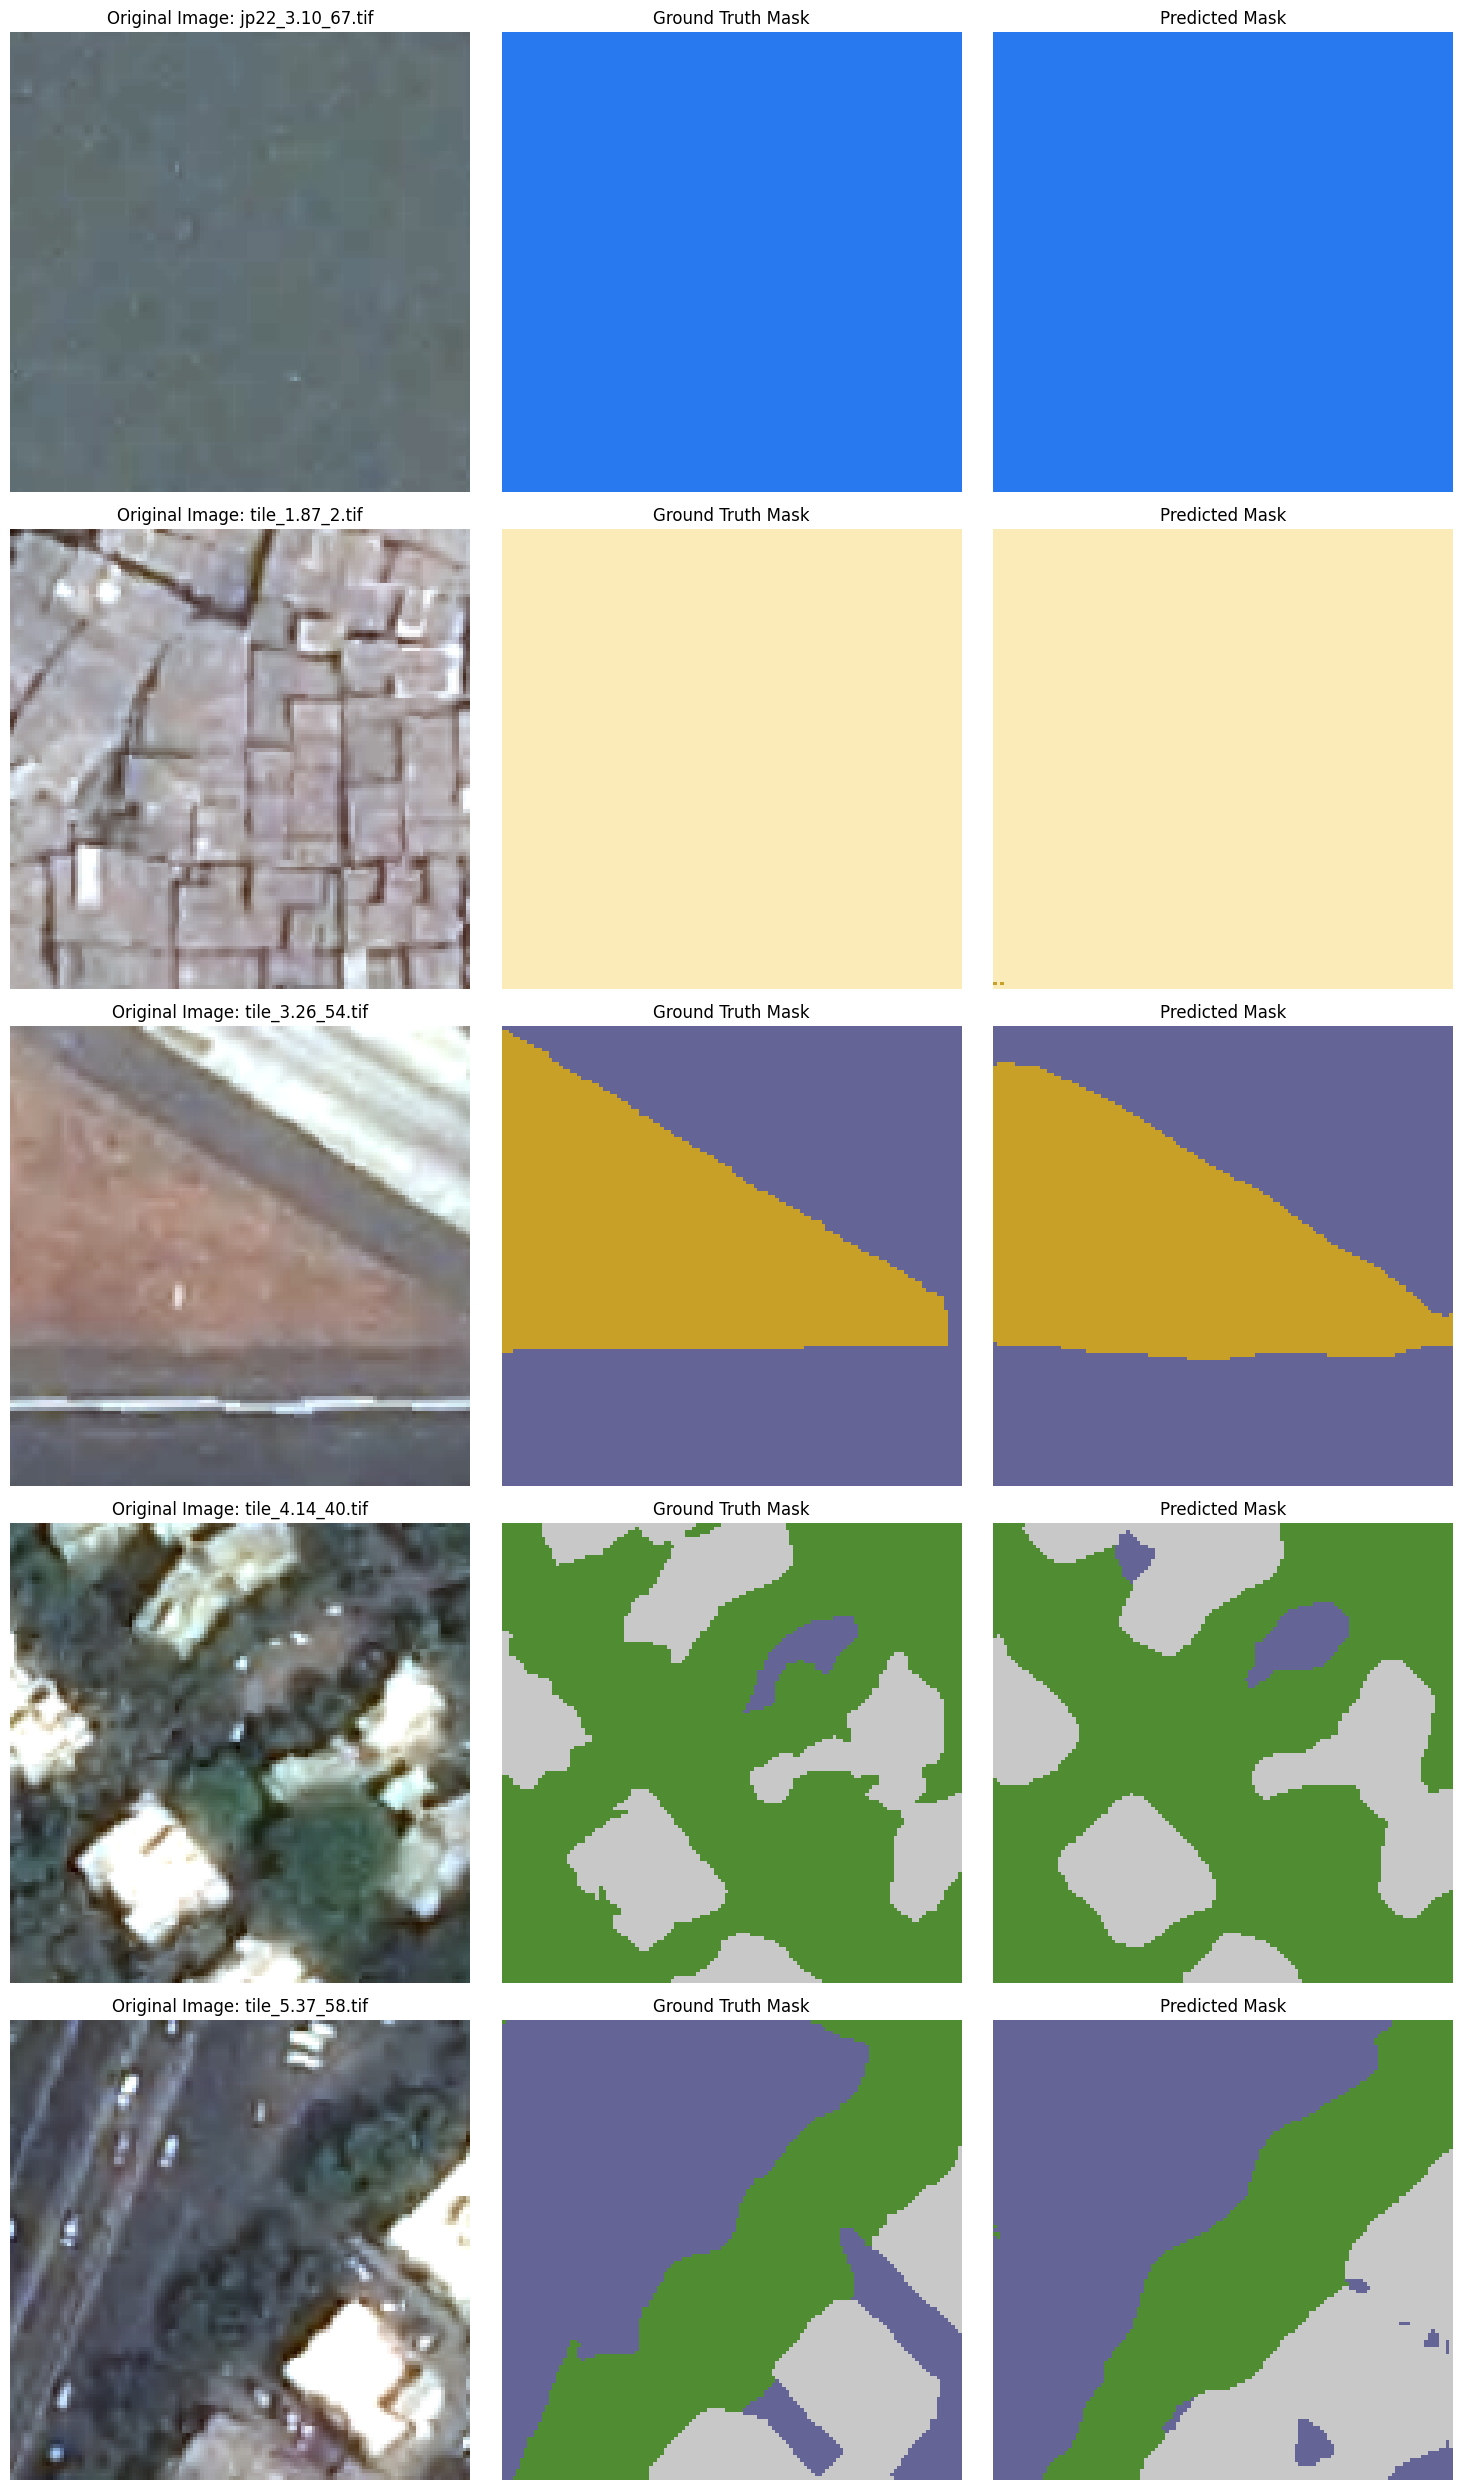

In [83]:
visualize_predictions_grid(visualization_images, test_dataset, model_7, class_dict_path, device)

In [87]:
def compare_models(model_stats, model_names):
    """
    Compare and visualize important results for a list of models.

    Args:
        model_stats (dict): Dictionary containing model metrics.
        model_names (list): List of model names to compare, e.g., ['model_1', 'model_2'].
    """
    # Check if all requested models exist in the stats
    for model in model_names:
        if model not in model_stats:
            raise ValueError(f"Model '{model}' not found in model_stats!")

    # Extract metrics for each model
    avg_metrics_list = ["avg_jaccard", "avg_dice", "avg_precision", "avg_recall"]
    class_metrics_list = ["class_iou", "class_dice"]

    # --- Plot Average Metrics ---
    avg_metrics_data = {metric: [] for metric in avg_metrics_list}

    for model in model_names:
        for metric in avg_metrics_list:
            avg_metrics_data[metric].append(model_stats[model]['avg_metrics'][metric])

    # Plot average metrics
    fig, axs = plt.subplots(1, len(avg_metrics_list), figsize=(18, 5))
    for i, metric in enumerate(avg_metrics_list):
        axs[i].bar(model_names, avg_metrics_data[metric], color='skyblue')
        axs[i].set_title(f"{metric.replace('_', ' ').title()} Comparison")
        axs[i].set_ylabel(metric.title())
        axs[i].set_xlabel("Models")
        axs[i].set_xticks(range(len(model_names)))
        axs[i].set_xticklabels(model_names, rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Plot Class-Wise Metrics ---
    for class_metric in class_metrics_list:
        class_data = {model: model_stats[model]['class_metrics'][class_metric] for model in model_names}

        # Convert class-wise metrics to a numpy array for easier plotting
        num_classes = len(class_data[model_names[0]])
        width = 0.1  # Width of each bar
        gap = 0.4    # Gap between classes
        x = np.arange(0, num_classes * (1 + gap), 1 + gap)  # Add gaps between classes

        # Plot class-wise metrics for each model
        fig, ax = plt.subplots(figsize=(12, 6))

        for i, model in enumerate(model_names):
            offset = i * width
            ax.bar(x + offset, class_data[model], width, label=model)

        ax.set_title(f"{class_metric.replace('_', ' ').title()} Comparison Across Classes")
        ax.set_xlabel("Classes")
        ax.set_ylabel(class_metric.replace("_", " ").title())
        ax.set_xticks(x + (len(model_names) - 1) * width / 2)
        ax.set_xticklabels([f"Class {i}" for i in range(num_classes)])
        ax.legend()
        plt.tight_layout()
        plt.show()


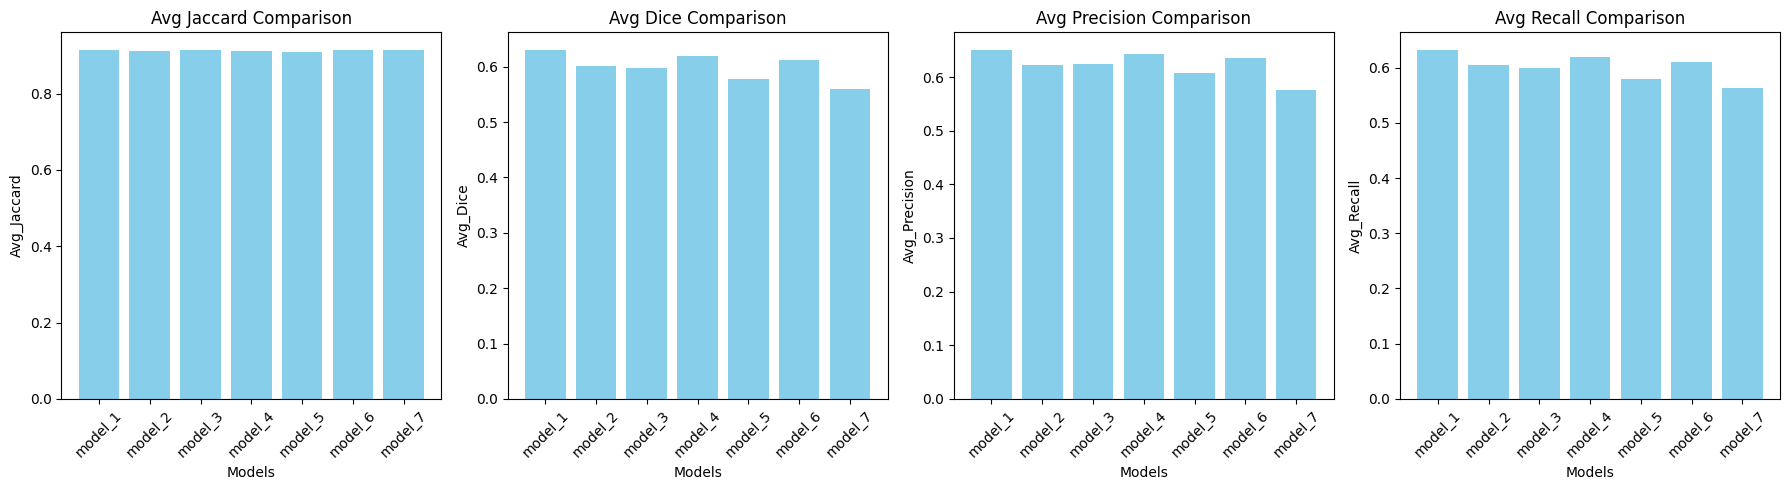

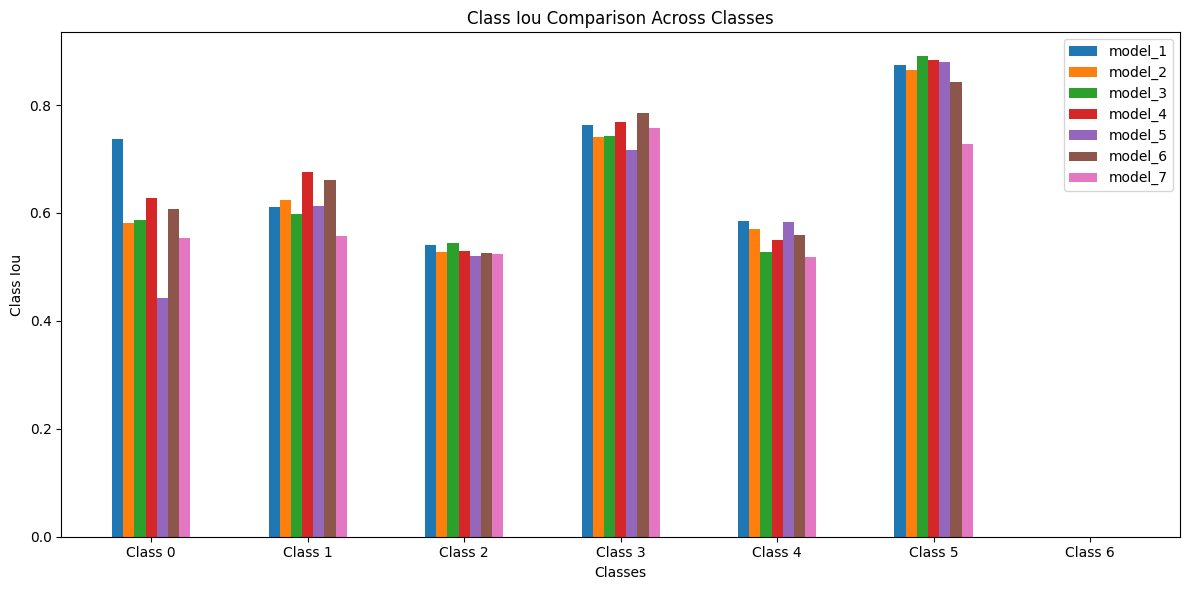

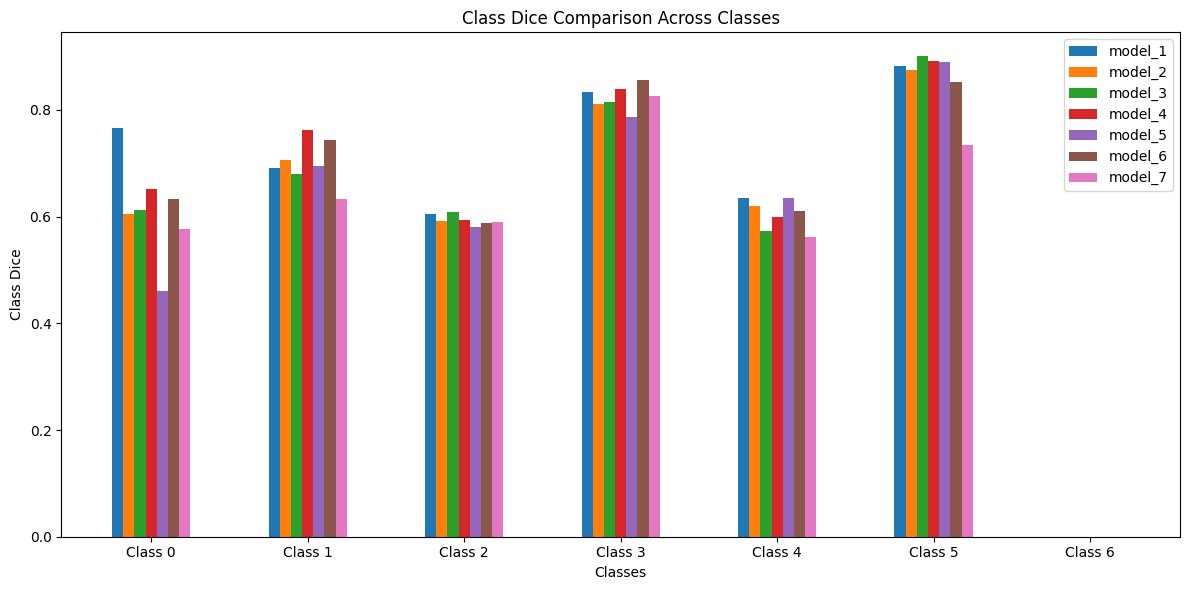

In [88]:
compare_models(model_stats, ['model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7'])

In [6]:
def ensemble_predict_preloaded(models, dataloader, device="cuda", method="mean"):
    """
    Perform ensemble prediction using preloaded models with different architectures.

    Args:
        models (list of nn.Module): List of trained models (already loaded).
        dataloader (torch.utils.data.DataLoader): DataLoader for test/validation data.
        device (str): Device to perform computations on ("cuda" or "cpu").
        method (str): Aggregation method, either "mean" (average logits) or "vote" (majority voting).

    Returns:
        list of torch.Tensor: List of aggregated predictions for each batch.
    """
    aggregated_predictions = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)

            # Initialize an empty tensor to store model predictions
            all_logits = []

            # Collect predictions from each model
            for model in models:
                model = model.to(device)
                model.eval()  # Ensure the model is in evaluation mode
                logits = model(images)  # Get raw logits
                all_logits.append(logits)

            # Stack predictions into a single tensor
            all_logits = torch.stack(all_logits, dim=0)  # Shape: (num_models, batch_size, num_classes, H, W)

            # Aggregate predictions
            if method == "mean":
                aggregated_logits = torch.mean(all_logits, dim=0)  # Average the logits across models
                predictions = torch.argmax(F.softmax(aggregated_logits, dim=1), dim=1)  # Get the class with max probability
            elif method == "vote":
                votes = torch.argmax(F.softmax(all_logits, dim=2), dim=2)  # Get predictions from each model
                predictions = torch.mode(votes, dim=0).values  # Majority vote for each pixel

            aggregated_predictions.append(predictions)

    return aggregated_predictions

def evaluate_ensemble(models, test_loader, device, n_classes, method="mean"):
    """
    Evaluate an ensemble of models on the test dataset and compute overall and class-wise metrics.

    Args:
        models: List of trained PyTorch models.
        test_loader: DataLoader for the test dataset.
        device: Device to perform computation on ('cuda' or 'cpu').
        n_classes: Number of segmentation classes.
        method: Aggregation method, either "mean" (average logits) or "vote" (majority voting).

    Returns:
        avg_metrics: Dictionary containing average metrics (IoU, Dice, Precision, Recall).
        class_metrics: Dictionary containing class-wise IoU, Dice, Precision, Recall.
    """
    for model in models:
        model.to(device)
        model.eval()

    jaccard_scores = []
    class_iou = np.zeros(n_classes)
    class_dice = np.zeros(n_classes)
    class_precision = np.zeros(n_classes)
    class_recall = np.zeros(n_classes)
    class_counts = np.zeros(n_classes)

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Collect predictions from each model
            all_logits = []
            for model in models:
                logits = model(images)
                all_logits.append(logits)

            # Stack logits and aggregate based on method
            all_logits = torch.stack(all_logits, dim=0)
            if method == "mean":
                aggregated_logits = torch.mean(all_logits, dim=0)
            elif method == "vote":
                votes = torch.argmax(F.softmax(all_logits, dim=2), dim=2)
                aggregated_logits = torch.mode(votes, dim=0).values
            else:
                raise ValueError("Unsupported aggregation method. Use 'mean' or 'vote'.")

            preds = torch.argmax(F.softmax(aggregated_logits, dim=1), dim=1)

            # Compute metrics for each sample
            for pred, mask in zip(preds, masks):
                pred_np = pred.cpu().numpy()
                mask_np = mask.cpu().numpy()

                pred_flat = pred_np.flatten()
                mask_flat = mask_np.flatten()

                jaccard = jaccard_score(mask_flat, pred_flat, average="weighted", zero_division=0)
                jaccard_scores.append(jaccard)

                for class_idx in range(n_classes):
                    pred_bin = (pred_np == class_idx).astype(np.uint8)
                    mask_bin = (mask_np == class_idx).astype(np.uint8)

                    intersection = np.sum(pred_bin * mask_bin)
                    union = np.sum(pred_bin) + np.sum(mask_bin)

                    if union > 0:
                        class_iou[class_idx] += intersection / (union - intersection)
                        class_dice[class_idx] += 2 * intersection / (np.sum(pred_bin) + np.sum(mask_bin))
                        class_precision[class_idx] += precision_score(mask_bin.flatten(), pred_bin.flatten(), zero_division=0)
                        class_recall[class_idx] += recall_score(mask_bin.flatten(), pred_bin.flatten(), zero_division=0)
                        class_counts[class_idx] += 1

    # Normalize class-wise metrics by counts
    class_iou = np.divide(class_iou, class_counts, out=np.zeros_like(class_iou), where=class_counts > 0)
    class_dice = np.divide(class_dice, class_counts, out=np.zeros_like(class_dice), where=class_counts > 0)
    class_precision = np.divide(class_precision, class_counts, out=np.zeros_like(class_precision), where=class_counts > 0)
    class_recall = np.divide(class_recall, class_counts, out=np.zeros_like(class_recall), where=class_counts > 0)

    avg_metrics = {
        "avg_jaccard": np.mean(jaccard_scores),
        "avg_precision": np.mean(class_precision),
        "avg_recall": np.mean(class_recall),
        "avg_dice": np.mean(class_dice)
    }

    class_metrics = {
        "class_iou": class_iou.tolist(),
        "class_dice": class_dice.tolist(),
        "class_precision": class_precision.tolist(),
        "class_recall": class_recall.tolist()
    }

    print(f"Average Metrics: {avg_metrics}")
    print(f"Class-wise Metrics: {class_metrics}")

    return avg_metrics, class_metrics

def visualize_ensemble_predictions(filenames, dataset, models, class_dict_path, device, method="mean", n_cols=3):
    """
    Visualize ensemble predictions in a grid layout.

    Args:
        filenames: List of filenames to visualize.
        dataset: The PyTorch dataset containing the images and masks.
        models: List of trained PyTorch models for semantic segmentation.
        class_dict_path: Path to the CSV file mapping class indices to RGB colors.
        device: Device ('cuda' or 'cpu') to run the models.
        method: Aggregation method, either "mean" (average logits) or "vote" (majority voting).
        n_cols: Number of columns in the grid. Default is 3 (original, ground truth, prediction).
    """
    class_dict = pd.read_csv(class_dict_path)
    rgb_mapping = {class_idx: (row['r'], row['g'], row['b']) for class_idx, row in class_dict.iterrows()}
    samples = fetch_samples_by_filenames(dataset, filenames)

    for model in models:
        model.to(device)
        model.eval()

    n_rows = len(samples)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for row, (image, mask, file_name) in enumerate(samples):
        image = image.to(device).unsqueeze(0)
        all_logits = [model(image) for model in models]

        all_logits = torch.stack(all_logits, dim=0)
        if method == "mean":
            aggregated_logits = torch.mean(all_logits, dim=0)
        elif method == "vote":
            votes = torch.argmax(F.softmax(all_logits, dim=2), dim=2)
            aggregated_logits = torch.mode(votes, dim=0).values
        preds = torch.argmax(F.softmax(aggregated_logits, dim=1), dim=1).squeeze(0).cpu().numpy()

        image_np = image[0].cpu().permute(1, 2, 0).numpy()
        mask_np = mask.cpu().numpy()

        def map_mask_to_rgb(mask, mapping):
            h, w = mask.shape
            rgb_image = np.zeros((h, w, 3), dtype=np.uint8)
            for class_idx, rgb in mapping.items():
                rgb_image[mask == class_idx] = rgb
            return rgb_image

        mask_rgb = map_mask_to_rgb(mask_np, rgb_mapping)
        preds_rgb = map_mask_to_rgb(preds, rgb_mapping)

        axes[row, 0].imshow(image_np)
        axes[row, 0].set_title(f"Original Image: {file_name}")
        axes[row, 0].axis("off")

        axes[row, 1].imshow(mask_rgb)
        axes[row, 1].set_title("Ground Truth Mask")
        axes[row, 1].axis("off")

        axes[row, 2].imshow(preds_rgb)
        axes[row, 2].set_title("Ensemble Prediction")
        axes[row, 2].axis("off")

    plt.tight_layout()
    plt.show()

model_1 = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights=None,
    in_channels=3,
    classes=7
)
model_1.load_state_dict(torch.load("models/n_first_unet_model.pth", weights_only=True))

model_4 = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights=None,
    in_channels=3,
    classes=7,
    encoder_depth=4,
    decoder_channels=[256, 128, 64, 32]
)
model_4.load_state_dict(torch.load("models/n_fourth_unet_model.pth", weights_only=True))

model_6 = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights=None,
    in_channels=3,
    classes=7,
    encoder_depth=4,
    decoder_channels=[256, 128, 64, 32],
    decoder_attention_type='scse'
)
model_6.load_state_dict(torch.load("models/n_sixth_unet_model.pth", weights_only=True))

models = [model_1, model_4, model_6]

In [7]:
evaluate_ensemble(models, test_loader, device, 7, method="mean")

Average Metrics: {'avg_jaccard': 0.918194056395666, 'avg_precision': 0.7019832362747106, 'avg_recall': 0.6745556667913847, 'avg_dice': 0.6761697610848544}
Class-wise Metrics: {'class_iou': [0.7986970383881288, 0.7107562902473563, 0.561685963565064, 0.7879066526811338, 0.6336165908156368, 0.9325001644032952, 0.0], 'class_dice': [0.8289333081639595, 0.7959762343560444, 0.6246946683141739, 0.8555734593930371, 0.6857310338963203, 0.9422796234704465, 0.0], 'class_precision': [0.833291445928867, 0.8264373259709175, 0.7196442560729644, 0.8562522483211817, 0.7248139769535804, 0.9534434006754632, 0.0], 'class_recall': [0.8347537421136951, 0.7983160009338924, 0.598802885266318, 0.872543148809176, 0.6796079784507579, 0.9378659119658533, 0.0]}


({'avg_jaccard': 0.918194056395666,
  'avg_precision': 0.7019832362747106,
  'avg_recall': 0.6745556667913847,
  'avg_dice': 0.6761697610848544},
 {'class_iou': [0.7986970383881288,
   0.7107562902473563,
   0.561685963565064,
   0.7879066526811338,
   0.6336165908156368,
   0.9325001644032952,
   0.0],
  'class_dice': [0.8289333081639595,
   0.7959762343560444,
   0.6246946683141739,
   0.8555734593930371,
   0.6857310338963203,
   0.9422796234704465,
   0.0],
  'class_precision': [0.833291445928867,
   0.8264373259709175,
   0.7196442560729644,
   0.8562522483211817,
   0.7248139769535804,
   0.9534434006754632,
   0.0],
  'class_recall': [0.8347537421136951,
   0.7983160009338924,
   0.598802885266318,
   0.872543148809176,
   0.6796079784507579,
   0.9378659119658533,
   0.0]})

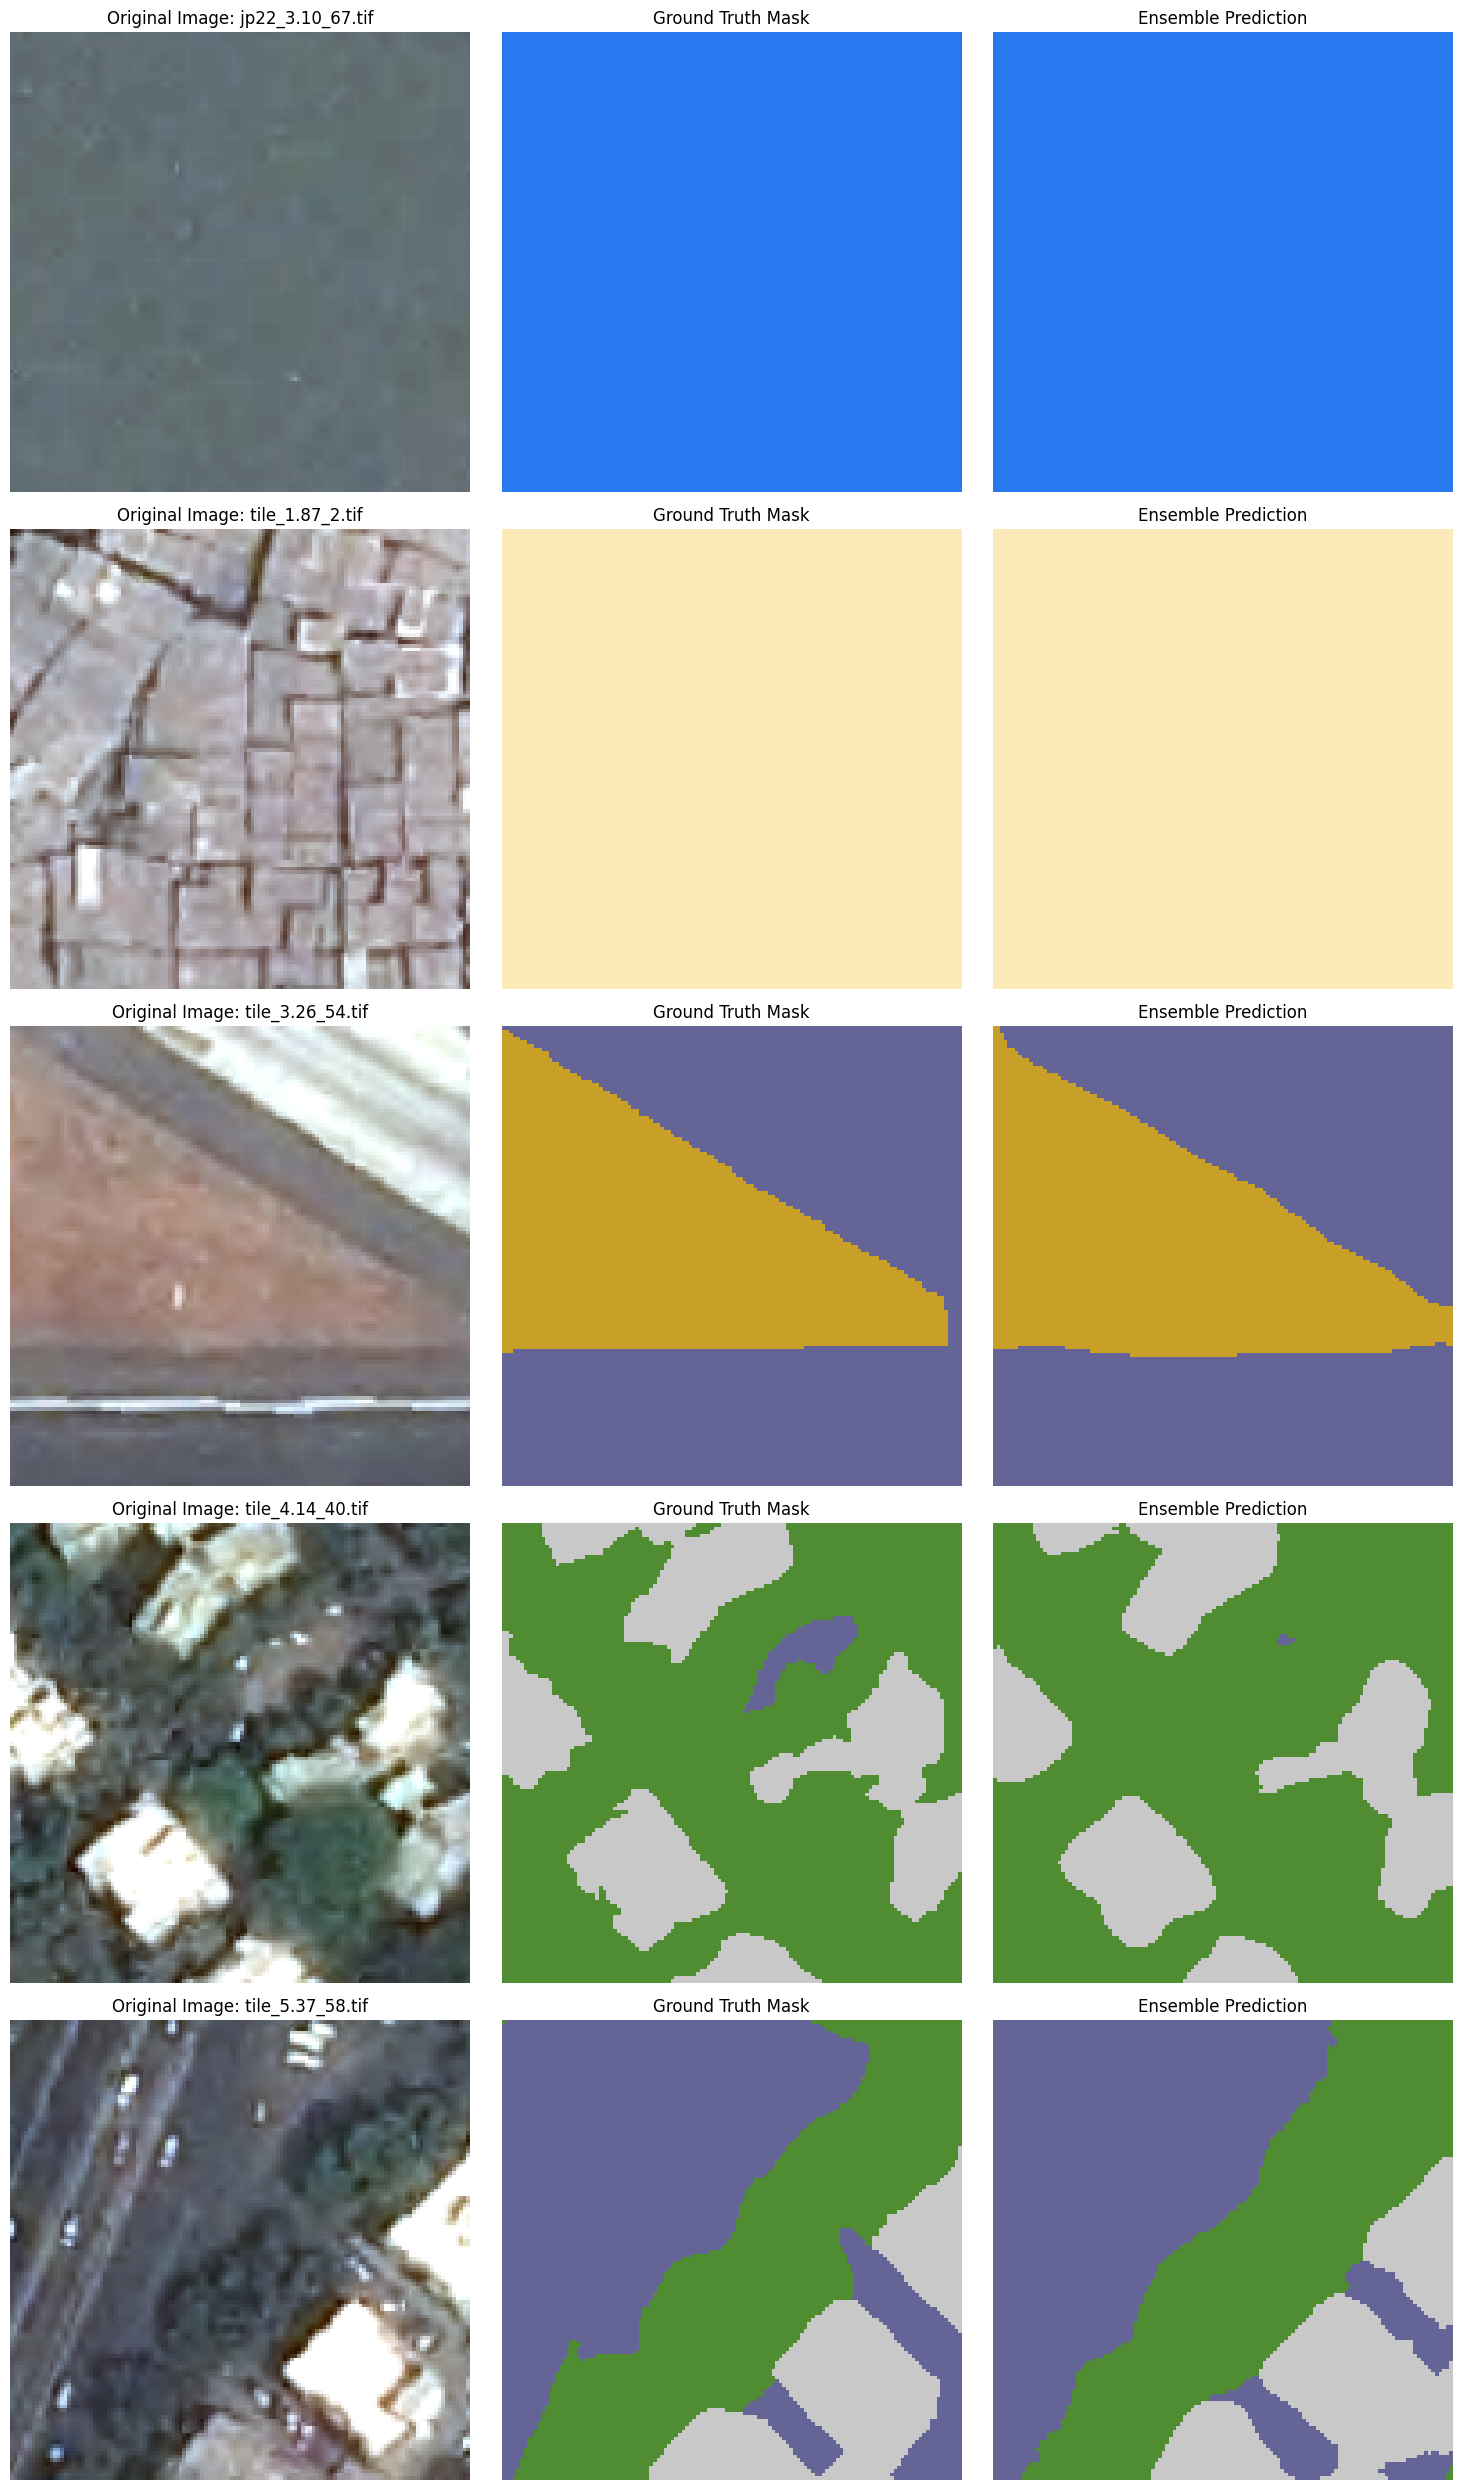

In [10]:
visualize_ensemble_predictions(visualization_images, test_dataset, models, class_dict_path, device, method="mean", n_cols=3)